# Baseline Model training for Contrails image segmentation

In [16]:
import pandas as pd
import numpy as np
from matplotlib import animation
import matplotlib.pyplot as plt
import time
import pickle
import os

import tensorflow as tf
from tensorflow import keras

# Converts categorical integers to one hot encoding 0 and 1
from keras.utils import to_categorical

# Import necessary keras libraries for UNET
from keras.models import Model, load_model
from keras.applications import ResNet50
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Concatenate, concatenate, BatchNormalization, Dropout, Lambda
from keras.layers import Flatten, LayerNormalization, Activation, MultiHeadAttention, Add, Dense, Reshape, RepeatVector, AveragePooling2D
from keras import losses
from keras import backend as K
# backend is tensor flow. At tensor level calculation, Keras does not cover it. Keras is only the framework. All backend methods are referred as K


os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
tf.keras.backend.clear_session()

import multiprocessing


In [32]:
# Basline variables
BATCH_SIZE = 32
total_classes = 2
IMAGE_CHANNELS = 3
# Hyper Parameters
NUM_EPOCHS = 50

BASE_DIR = "../../../filestore_mount/contrails-data/"
TRAIN_DIR = BASE_DIR + "train/"
VALIDATION_DIR = BASE_DIR + "validation/"
TEST_DIR = BASE_DIR + "test/"
validation_ids = os.listdir(VALIDATION_DIR)
test_ids = os.listdir(TEST_DIR)
MODELS_PATH = "../models/"
TRAIN_HISTORY_PATH = MODELS_PATH + "train_history/"


In [47]:
# Helper Functions

# Variables used to normalize and build Ash images 

_T11_BOUNDS = (243, 303)
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
_TDIFF_BOUNDS = (-4, 2)

class DataGenerator(keras.utils.Sequence):
    """ 
    This is a Keras Data generator used to load the images in batches for training.
    The Kaggle flag is used to build the ash images at runtime, instead of loading pre-built images from disk
    The time_series flag is used to pass the 8 time-series images from the ash image instead of only getting the 5th time-series image [...,4]
    The test flag is used to build the test dataset when submitting to Kaggle since it does not return a label, it just creates the ash image at runtime
    """
    
    def __init__(self, list_IDs, image_channels=3, batch_size=32, multiple_bands=False, shuffle=True, test=False, kaggle=False, time_series=False):
        'Initialization'
        self.indexes = np.arange(len(list_IDs))
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle 
        self.image_channels = image_channels
        self.test = test
        self.on_epoch_end()
        self.kaggle = kaggle
        self.time_series = time_series
        self.multiple_bands = multiple_bands

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
            
        if self.test:
            X = []
            for record_id in list_IDs_temp:
                if self.multiple_bands:
                    X.append(self.get_multiple_bands_image(record_id))
                else:
                    X.append(self.get_ash_image(record_id))
            return np.asarray(X)
        else:
            X = []
            y = []

            for record_id in list_IDs_temp:
                if self.multiple_bands:
                    X.append(self.get_multiple_bands_image(record_id))
                else:
                    X.append(self.get_ash_image(record_id))
                y.append(np.load(record_id[0] + str(record_id[1]) + '/human_pixel_masks.npy'))
            return np.asarray(X), keras.utils.to_categorical(np.asarray(y), num_classes=2)
    
    def normalize_range(self, data, bounds):
        """Maps data to the range [0, 1]."""
        return (data - bounds[0]) / (bounds[1] - bounds[0])

    def normalize_std(self, spec):
        return (spec- np.mean(spec))/np.std(spec)

    def get_multiple_bands_image(self, record_id):
        # Gets image_id string with the filder prexix included in the name
        # Returns numpy array with image and local path
        if self.kaggle:
            band_11 = np.load(record_id[0] + str(record_id[1]) + '/band_11.npy')
            band_13 = np.load(record_id[0] + str(record_id[1]) + '/band_13.npy')
            band_14 = np.load(record_id[0] + str(record_id[1]) + '/band_14.npy')
            band_15 = np.load(record_id[0] + str(record_id[1]) + '/band_15.npy')
            r = self.normalize_range(band_15 - band_14, _TDIFF_BOUNDS)
            g = self.normalize_range(band_14 - band_11, _CLOUD_TOP_TDIFF_BOUNDS)
            b = self.normalize_range(band_14, _T11_BOUNDS)

            

            if self.time_series:
                multiple_bands_image = np.np.clip(np.stack([r,g,b,self.normalize_std(band_11), self.normalize_std(band_13), 
                                                          self.normalize_std(band_14), self.normalize_std(band_16)], axis=2), 0, 1)[...,2:5].reshape(256,256,3*self.image_channels)
            else:
                multiple_bands_image = np.clip(np.stack([r,g,b,self.normalize_std(band_11), self.normalize_std(band_13), 
                                                          self.normalize_std(band_14), self.normalize_std(band_16)], axis=2), 0, 1)[...,4]
        else:
            if self.time_series:
                multiple_bands_image = np.load(record_id[0] + str(record_id[1]) + '/multiple_bands_image.npy')[...,2:5].reshape(256,256,self.image_channels)
            else:
                multiple_bands_image = np.load(record_id[0] + str(record_id[1]) + '/multiple_bands_image.npy')[...,4]
        return multiple_bands_image
    
    
    def get_ash_image(self, record_id):
        # Gets image_id string with the filder prexix included in the name
        # Returns numpy array with image and local path
        if self.kaggle:
            band_11 = np.load(record_id[0] + str(record_id[1]) + '/band_11.npy')
            band_14 = np.load(record_id[0] + str(record_id[1]) + '/band_14.npy')
            band_15 = np.load(record_id[0] + str(record_id[1]) + '/band_15.npy')

            r = self.normalize_range(band_15 - band_14, _TDIFF_BOUNDS)
            g = self.normalize_range(band_14 - band_11, _CLOUD_TOP_TDIFF_BOUNDS)
            b = self.normalize_range(band_14, _T11_BOUNDS)
            if self.time_series:
                ash_image = np.clip(np.stack([r, g, b], axis=2), 0, 1)[...,2:5].reshape(256,256,self.image_channels)
            else:
                ash_image = np.clip(np.stack([r, g, b], axis=2), 0, 1)[...,4]
        else:
            if self.time_series:
                ash_image = np.load(record_id[0] + str(record_id[1]) + '/ash_image.npy')[...,2:5].reshape(256,256,self.image_channels)
            else:
                ash_image = np.load(record_id[0] + str(record_id[1]) + '/ash_image.npy')[...,4]
        return ash_image
 
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            

def multi_unet_model(n_classes=2, image_height=256, image_width=256, image_channels=3):
    """
    This function built by Prakash defines and returns a UNET model
    """
    inputs = Input((image_height, image_width, image_channels)) # Here 256, 256, 3

    source_input = inputs

    # First Block in U-Net Architecture
    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
    p1 = MaxPooling2D((2,2))(c1)

    # Second Block in U-Net Architecture (increase filters to 32 from 16)
    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
    p2 = MaxPooling2D((2,2))(c2)

    # Third Block in U-Net Architecture (increase filters to 64 from 32)
    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
    p3 = MaxPooling2D((2,2))(c3)

    # 4th Block in U-Net Architecture (increase filters to 128 from 64)
    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
    p4 = MaxPooling2D((2,2))(c4)

    # 5th Block in U-Net Architecture (increase filters to 256 from 128)
    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

    outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


def trans_unet_model(n_classes=2, image_height=256, image_width=256, image_channels=3):
    """ 
    This function built by Prakash defines and returns a UNET model with transformer step
    """
    inputs = Input((image_height, image_width, image_channels)) # Here 256, 256, 3

    source_input = inputs

    # First Block in U-Net Architecture
    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
    p1 = MaxPooling2D((2,2))(c1)

    # Second Block in U-Net Architecture (increase filters to 32 from 16)
    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
    p2 = MaxPooling2D((2,2))(c2)

    # Third Block in U-Net Architecture (increase filters to 64 from 32)
    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
    p3 = MaxPooling2D((2,2))(c3)

    # 4th Block in U-Net Architecture (increase filters to 128 from 64)
    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
    p4 = MaxPooling2D((2,2))(c4)

    # 5th Block in U-Net Architecture (increase filters to 256 from 128)
    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

    #Transformer Layer
#     VIZ_TRANFORMER_UNITS = 256
#     x1 = Flatten()(p3) #pass in 2x2 patches encoded, p1
#     x1 = Reshape((-1,1, VIZ_TRANFORMER_UNITS))(Dense(VIZ_TRANFORMER_UNITS)(x1)) #linear projection

#     for i in range(12):
#         x1n = LayerNormalization(epsilon=1e-6)(x1)
#         attention_output = MultiHeadAttention(num_heads=8, key_dim=VIZ_TRANFORMER_UNITS)(x1n,x1n)
#         x2 = Add()([attention_output, x1])
#         x3 = LayerNormalization(epsilon=1e-6)(x2)
#         x1 = Dense(VIZ_TRANFORMER_UNITS, activation='relu')(x3)
    VIZ_TRANFORMER_UNITS = 256
    x1 = Flatten()(p3) #pass in 2x2 patches encoded, p1
    x1 = Reshape((-1,1, VIZ_TRANFORMER_UNITS))(Dense(VIZ_TRANFORMER_UNITS)(x1)) #linear projection
    for i in range(24):
        x1n = LayerNormalization(epsilon=1e-6)(x1)
        attention_output = MultiHeadAttention(num_heads=8, key_dim=VIZ_TRANFORMER_UNITS)(x1n,x1n)
        x2 = Add()([attention_output, x1])
        x3 = LayerNormalization(epsilon=1e-6)(x2)
        x1 = Dense(VIZ_TRANFORMER_UNITS, activation='relu')(x3)
    
    
    #combine
    repeat_x1 = RepeatVector(16*256)(Reshape((VIZ_TRANFORMER_UNITS,))(x1))
    reshape_x1 = Reshape((256,256,16))(repeat_x1)

    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
    u9 = concatenate([u9, c1, reshape_x1], axis=3)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

    outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model



def ASPP(inputs):
    """ 
    Function provided by Prakash used to build Atrous Spatial Pyramid Pooling which is needed for DeeplabV3+ model
    """
    shape = inputs.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]), name='average_pooling')(inputs)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)
    y_1 = Activation('relu')(y_1)

    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same', use_bias=False)(inputs)
    y_6 = BatchNormalization()(y_6)
    y_6 = Activation('relu')(y_6)

    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same', use_bias=False)(inputs)
    y_12 = BatchNormalization()(y_12)
    y_12 = Activation('relu')(y_12)

    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same', use_bias=False)(inputs)
    y_18 = BatchNormalization()(y_18)
    y_18 = Activation('relu')(y_18)

    y = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    return y

def DeepLabV3Plus(shape):
    """ 
    This function built by Prakash creates a DeepLabV3+ model using ResNet50 architecture with pretrained imagenet weights
    """
    
    inputs = Input(shape)

    """ Pre-trained ResNet50 """
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    """ Pre-trained ResNet50 Output """
    image_features = base_model.get_layer('conv4_block6_out').output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    """ Get low-level features """
    x_b = base_model.get_layer('conv2_block2_out').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    x = Concatenate()([x_a, x_b])

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((4, 4), interpolation="bilinear")(x)

    # """ Outputs """
    # x = Conv2D(2, (1, 1), name='output_layer')(x)
    # x = Activation('softmax')(x)

    # """ Model """
    # model = Model(inputs=inputs, outputs=x)

    outputs = Conv2D(2, (1,1), activation="softmax")(x)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model
        
    
def jaccard_coef(y_true, y_pred):
    """
    Defines custom jaccard coefficient metric
    """
    
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
    return final_coef_value



def real_dice_coeff(y_true, y_pred):
    smooth = 0.0001
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    dice_score = (2.0 * intersection + smooth) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) + smooth)
    return dice_score


def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

class LearningRateTracker(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        optimizer = self.model.optimizer
        _lr = tf.keras.backend.get_value(optimizer.lr)
        print(f'\nEpoch {epoch+1}: Learning rate is {_lr:.4f}.')

        

def train_model(model, model_name, epochs=NUM_EPOCHS, models_path=MODELS_PATH, train_history_path=TRAIN_HISTORY_PATH):
    """
    Trains the specific model, saves it as keras model and the train history as pickle file
    """
    start_time = time.time()
    # Train the Model
    lr_tracker = LearningRateTracker()
    with tf.device('/device:GPU:0'):
        history = model.fit(training_generator,
                              validation_data=validation_generator,
                              epochs=epochs,
                              callbacks=[lr_tracker],
                              shuffle=True,
                              workers=4)
    training_duration = time.time() - start_time
    print(f"Training completed in: {training_duration} seconds")

    model.save(MODELS_PATH + model_name + ".keras")
    with open(train_history_path + model_name + '_train_history.pkl', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
        
    print(f'Model Saved at {MODELS_PATH}{model_name}.keras\n')
    

def visualize_train_curves(train_history, title):
    """ 
    This function plots the main metrics used during model training and prints the last epoch's metrics values
    """
    train_loss, train_iou_score, train_mean_iou, train_accuracy, train_jaccard_coef, train_dice_coeficient, val_loss, val_iou_score, val_mean_iou, val_accuracy, val_jaccard_coef, val_dice_coeficient  = train_history.values() 

     # Visualize loss Results
    epochs = range(1, len(train_history['loss']) + 1)
    
    fig, ax = plt.subplots(2, 2, figsize=(18, 10))
    fig.tight_layout(pad=5.0)


    l1, = ax[0, 0].plot(epochs, train_loss, 'g')
    l2, = ax[0, 0].plot(epochs, val_loss, 'r')
    ax[0, 0].set_title("Loss")
    ax[0, 0].set_xlabel("Epochs")
    ax[0, 0].set_ylabel("Loss")


    ax[0, 1].plot(epochs, train_mean_iou, 'g')
    ax[0, 1].plot(epochs, val_mean_iou, 'r')
    ax[0, 1].set_title("Mean IoU")
    ax[0, 1].set_ylabel("Mean IoU")
    ax[0, 1].set_xlabel("Epochs")


    ax[1,0].plot(epochs, train_jaccard_coef, 'g')
    ax[1,0].plot(epochs, val_jaccard_coef, 'r')
    ax[1,0].set_title("Jaccard Coef")
    ax[1,0].set_xlabel("Epochs")
    ax[1,0].set_ylabel("Jaccard Coef")


    ax[1,1].plot(epochs, train_dice_coeficient, 'g', label="Train Dice Coeficient")
    ax[1,1].plot(epochs, val_dice_coeficient, 'r', label="Val Dice Coeficient")
    ax[1,1].set_title("Dice Coeficient")
    ax[1,1].set_ylabel("Dice Coeficient")
    ax[1,1].set_xlabel("Epochs")
    fig.suptitle(title, fontsize=16)
    

    fig.legend((l1,l2),('Training', 'Validation'), loc='upper left')
    plt.show()
    
    print("Model's last epoch's metrics:")
    for item in train_history:
        print(f'{item} = {train_history[item][-1]:.4f}')
    


In [52]:
# Data loading

train_id_list = [(TRAIN_DIR, record_id) for record_id in os.listdir(TRAIN_DIR)]
validation_id_list = [(VALIDATION_DIR, record_id) for record_id in os.listdir(VALIDATION_DIR)]

""" full_id_list is only used to train in Kaggle using both Train and Validation records (images) """
full_id_list = train_id_list + validation_id_list

""" test_id_list is also only used in Kaggle to create the csv file needed for the submission """
test_id_list = [(TEST_DIR, record_id) for record_id in os.listdir(TEST_DIR)]



training_generator = DataGenerator(train_id_list, image_channels=3, batch_size=BATCH_SIZE, kaggle=False)
validation_generator = DataGenerator(validation_id_list, image_channels=3, batch_size=BATCH_SIZE, shuffle=True, test=False, kaggle=False)
# test_generator = DataGenerator(test_id_list, image_channels=3, batch_size=1, shuffle=False, test=True, kaggle=True)


# Models baseline parameters 

weights = [0.5,0.5] # hyper parameter

dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
TOTAL_LOSS_FACTOR = 5
total_loss = dice_loss + (TOTAL_LOSS_FACTOR * focal_loss)


metrics = [real_dice_coeff, tf.keras.metrics.MeanIoU(num_classes=2, sparse_y_true= False, sparse_y_pred=False, name="Mean IOU"), "accuracy", jaccard_coef, sm.metrics.FScore(threshold=0.6, name="Dice Coeficient")]




In [15]:
# Train Unet Model 
model = multi_unet_model()

model.compile(optimizer="adam", 
              loss=total_loss, 
              metrics=metrics)

model_name = "test_filestore_3_epochs"

history = train_model(model, model_name, epochs=5, models_path=MODELS_PATH, train_history_path=TRAIN_HISTORY_PATH)
    

2023-07-18 18:04:07.601690: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25165824 exceeds 10% of free system memory.


Epoch 1/5


2023-07-18 18:04:12.676738: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:959] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-07-18 18:04:22.033695: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25165824 exceeds 10% of free system memory.
2023-07-18 18:04:25.871287: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:434] Loaded cuDNN version 8900
2023-07-18 18:04:34.828031: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55bfe0bc5b10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-18 18:04:34.828071: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-07-18 18:04:35.933479: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRA

  1/641 [..............................] - ETA: 6:47:04 - loss: 1.0600 - real_dice_coeff: 0.4617 - Mean IOU: 0.1521 - accuracy: 0.3019 - jaccard_coef: 0.3001 - Dice Coeficient: 0.0330

2023-07-18 18:04:46.663017: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25165824 exceeds 10% of free system memory.


  2/641 [..............................] - ETA: 4:28 - loss: 0.9868 - real_dice_coeff: 0.5185 - Mean IOU: 0.2945 - accuracy: 0.5854 - jaccard_coef: 0.3520 - Dice Coeficient: 0.1422   

2023-07-18 18:04:47.033470: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25165824 exceeds 10% of free system memory.


  6/641 [..............................] - ETA: 4:13 - loss: 0.8710 - real_dice_coeff: 0.7842 - Mean IOU: 0.4250 - accuracy: 0.8458 - jaccard_coef: 0.6883 - Dice Coeficient: 0.3730

2023-07-18 18:04:48.601681: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25165824 exceeds 10% of free system memory.


641/641 [==============================] - ETA: 0s - loss: 0.7519 - real_dice_coeff: 0.9708 - Mean IOU: 0.5214 - accuracy: 0.9922 - jaccard_coef: 0.9447 - Dice Coeficient: 0.5278
Epoch 1: Learning rate is 0.0010.
641/641 [==============================] - 1555s 2s/step - loss: 0.7519 - real_dice_coeff: 0.9708 - Mean IOU: 0.5214 - accuracy: 0.9922 - jaccard_coef: 0.9447 - Dice Coeficient: 0.5278 - val_loss: 0.7374 - val_real_dice_coeff: 0.9945 - val_Mean IOU: 0.5339 - val_accuracy: 0.9965 - val_jaccard_coef: 0.9891 - val_Dice Coeficient: 0.5556
Epoch 2/5
641/641 [==============================] - ETA: 0s - loss: 0.7027 - real_dice_coeff: 0.9918 - Mean IOU: 0.5955 - accuracy: 0.9930 - jaccard_coef: 0.9838 - Dice Coeficient: 0.6514
Epoch 2: Learning rate is 0.0010.
641/641 [==============================] - 1529s 2s/step - loss: 0.7027 - real_dice_coeff: 0.9918 - Mean IOU: 0.5955 - accuracy: 0.9930 - jaccard_coef: 0.9838 - Dice Coeficient: 0.6514 - val_loss: 0.7045 - val_real_dice_coeff: 

# Model Training 

In [38]:
# Train Unet Model 
model = multi_unet_model()

model.compile(optimizer="adam", 
              loss=total_loss, 
              metrics=metrics)

model_name = "Baseline_Unet_Ash_Image_50_epochs"

history = train_model(model, model_name, epochs=NUM_EPOCHS, models_path=MODELS_PATH, train_history_path=TRAIN_HISTORY_PATH)
    

Epoch 1/50


2023-07-11 07:40:55.134537: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:959] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


641/641 [==============================] - 606s 925ms/step - loss: 0.7562 - IOU score: 0.4741 - Mean IOU: 0.5139 - accuracy: 0.9882 - jaccard_coef: 0.9408 - Dice Coeficient: 0.4927 - val_loss: 0.7438 - val_IOU score: 0.4976 - val_Mean IOU: 0.5252 - val_accuracy: 0.9973 - val_jaccard_coef: 0.9905 - val_Dice Coeficient: 0.4997
Epoch 2/50
641/641 [==============================] - 602s 934ms/step - loss: 0.7098 - IOU score: 0.5515 - Mean IOU: 0.5846 - accuracy: 0.9923 - jaccard_coef: 0.9826 - Dice Coeficient: 0.5972 - val_loss: 0.7072 - val_IOU score: 0.5508 - val_Mean IOU: 0.5729 - val_accuracy: 0.9976 - val_jaccard_coef: 0.9945 - val_Dice Coeficient: 0.5912
Epoch 3/50
641/641 [==============================] - 601s 934ms/step - loss: 0.6745 - IOU score: 0.6065 - Mean IOU: 0.6314 - accuracy: 0.9939 - jaccard_coef: 0.9868 - Dice Coeficient: 0.6768 - val_loss: 0.6725 - val_IOU score: 0.6030 - val_Mean IOU: 0.6211 - val_accuracy: 0.9979 - val_jaccard_coef: 0.9955 - val_Dice Coeficient: 0.66

2023-07-11 12:52:44.388901: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: TypeError: 'NoneType' object is not subscriptable
Traceback (most recent call last):

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/data_adapter.py", line 917, in wrapped_generator
    for data in generator_fn():

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/data_utils.py", line 871, in get
    raise e

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/data_utils.py", line 862, in get


Epoch 32/50
641/641 [==============================] - 602s 934ms/step - loss: 0.6137 - IOU score: 0.7121 - Mean IOU: 0.7240 - accuracy: 0.9960 - jaccard_coef: 0.9916 - Dice Coeficient: 0.7981 - val_loss: 0.6265 - val_IOU score: 0.6857 - val_Mean IOU: 0.6937 - val_accuracy: 0.9983 - val_jaccard_coef: 0.9965 - val_Dice Coeficient: 0.7676
Epoch 34/50
641/641 [==============================] - 602s 934ms/step - loss: 0.6127 - IOU score: 0.7137 - Mean IOU: 0.7257 - accuracy: 0.9960 - jaccard_coef: 0.9917 - Dice Coeficient: 0.7997 - val_loss: 0.6285 - val_IOU score: 0.6740 - val_Mean IOU: 0.6884 - val_accuracy: 0.9985 - val_jaccard_coef: 0.9968 - val_Dice Coeficient: 0.7555
Epoch 35/50
641/641 [==============================] - 602s 934ms/step - loss: 0.6121 - IOU score: 0.7149 - Mean IOU: 0.7270 - accuracy: 0.9960 - jaccard_coef: 0.9917 - Dice Coeficient: 0.8008 - val_loss: 0.6248 - val_IOU score: 0.6779 - val_Mean IOU: 0.6965 - val_accuracy: 0.9986 - val_jaccard_coef: 0.9971 - val_Dice Co

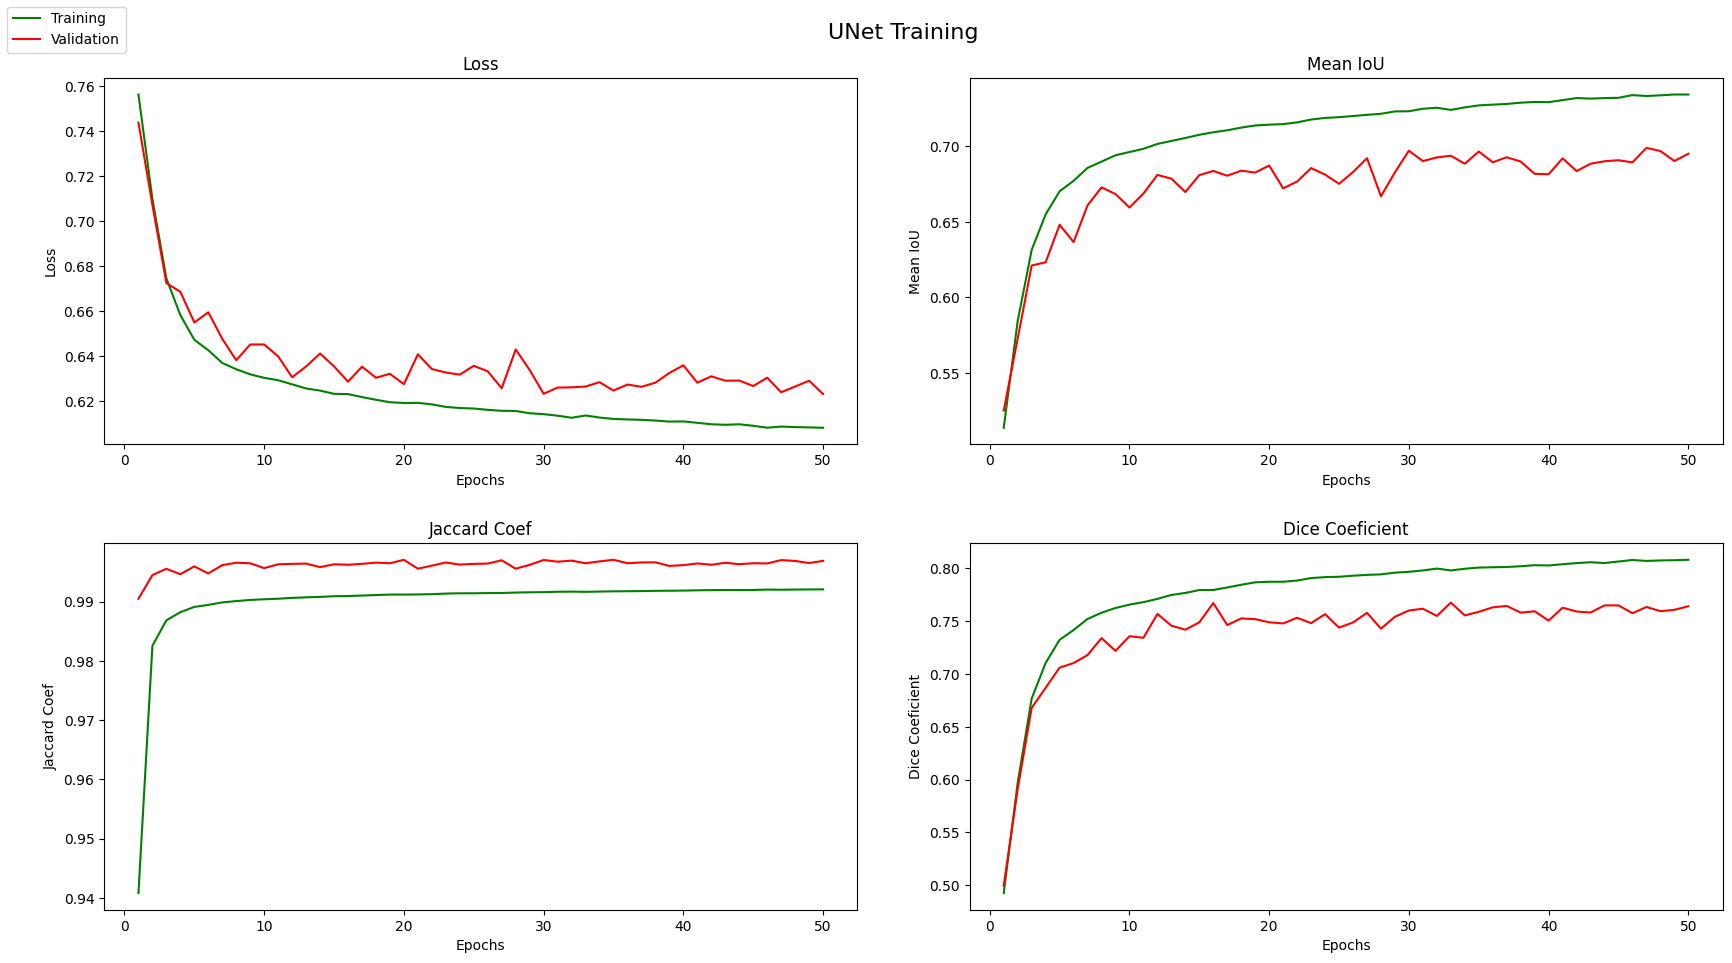

Model's last epoch's metrics:
loss = 0.6082
IOU score = 0.7224
Mean IOU = 0.7342
accuracy = 0.9962
jaccard_coef = 0.9921
Dice Coeficient = 0.8082
val_loss = 0.6232
val_IOU score = 0.6814
val_Mean IOU = 0.6951
val_accuracy = 0.9985
val_jaccard_coef = 0.9969
val_Dice Coeficient = 0.7642


In [16]:
# Plot Unet Training History
model_name = "Baseline_Unet_Ash_Image_50_epochs"
with open(TRAIN_HISTORY_PATH + model_name + '_train_history.pkl', 'rb') as pfile:
    train_history = pickle.load(pfile)
visualize_train_curves(train_history, "UNet Training")



In [40]:
# Train using UNET Resnet101 from segmentation_models package

model = sm.Unet('resnet101', encoder_weights='imagenet', classes=total_classes, activation='softmax')


model.compile(optimizer="adam", 
              loss=total_loss, 
              metrics=metrics)

model_name = "Baseline_Resnet101_Ash_Image_50_epochs"


train_model(model, model_name, epochs=NUM_EPOCHS, models_path=MODELS_PATH, train_history_path=TRAIN_HISTORY_PATH)
   

641/641 [==============================] - 768s 1s/step - loss: 0.7157 - IOU score: 0.4981 - Mean IOU: 0.5381 - accuracy: 0.9814 - jaccard_coef: 0.9105 - Dice Coeficient: 0.5557 - val_loss: 0.7651 - val_IOU score: 0.4993 - val_Mean IOU: 0.4995 - val_accuracy: 0.9982 - val_jaccard_coef: 0.9962 - val_Dice Coeficient: 0.4999
Epoch 2/50
641/641 [==============================] - 712s 1s/step - loss: 0.6403 - IOU score: 0.6613 - Mean IOU: 0.6805 - accuracy: 0.9952 - jaccard_coef: 0.9897 - Dice Coeficient: 0.7449 - val_loss: 0.6596 - val_IOU score: 0.6032 - val_Mean IOU: 0.6397 - val_accuracy: 0.9985 - val_jaccard_coef: 0.9968 - val_Dice Coeficient: 0.6661
Epoch 3/50
641/641 [==============================] - 710s 1s/step - loss: 0.6299 - IOU score: 0.6787 - Mean IOU: 0.6960 - accuracy: 0.9955 - jaccard_coef: 0.9904 - Dice Coeficient: 0.7640 - val_loss: 0.6489 - val_IOU score: 0.6310 - val_Mean IOU: 0.6569 - val_accuracy: 0.9984 - val_jaccard_coef: 0.9965 - val_Dice Coeficient: 0.7045
Epoch 

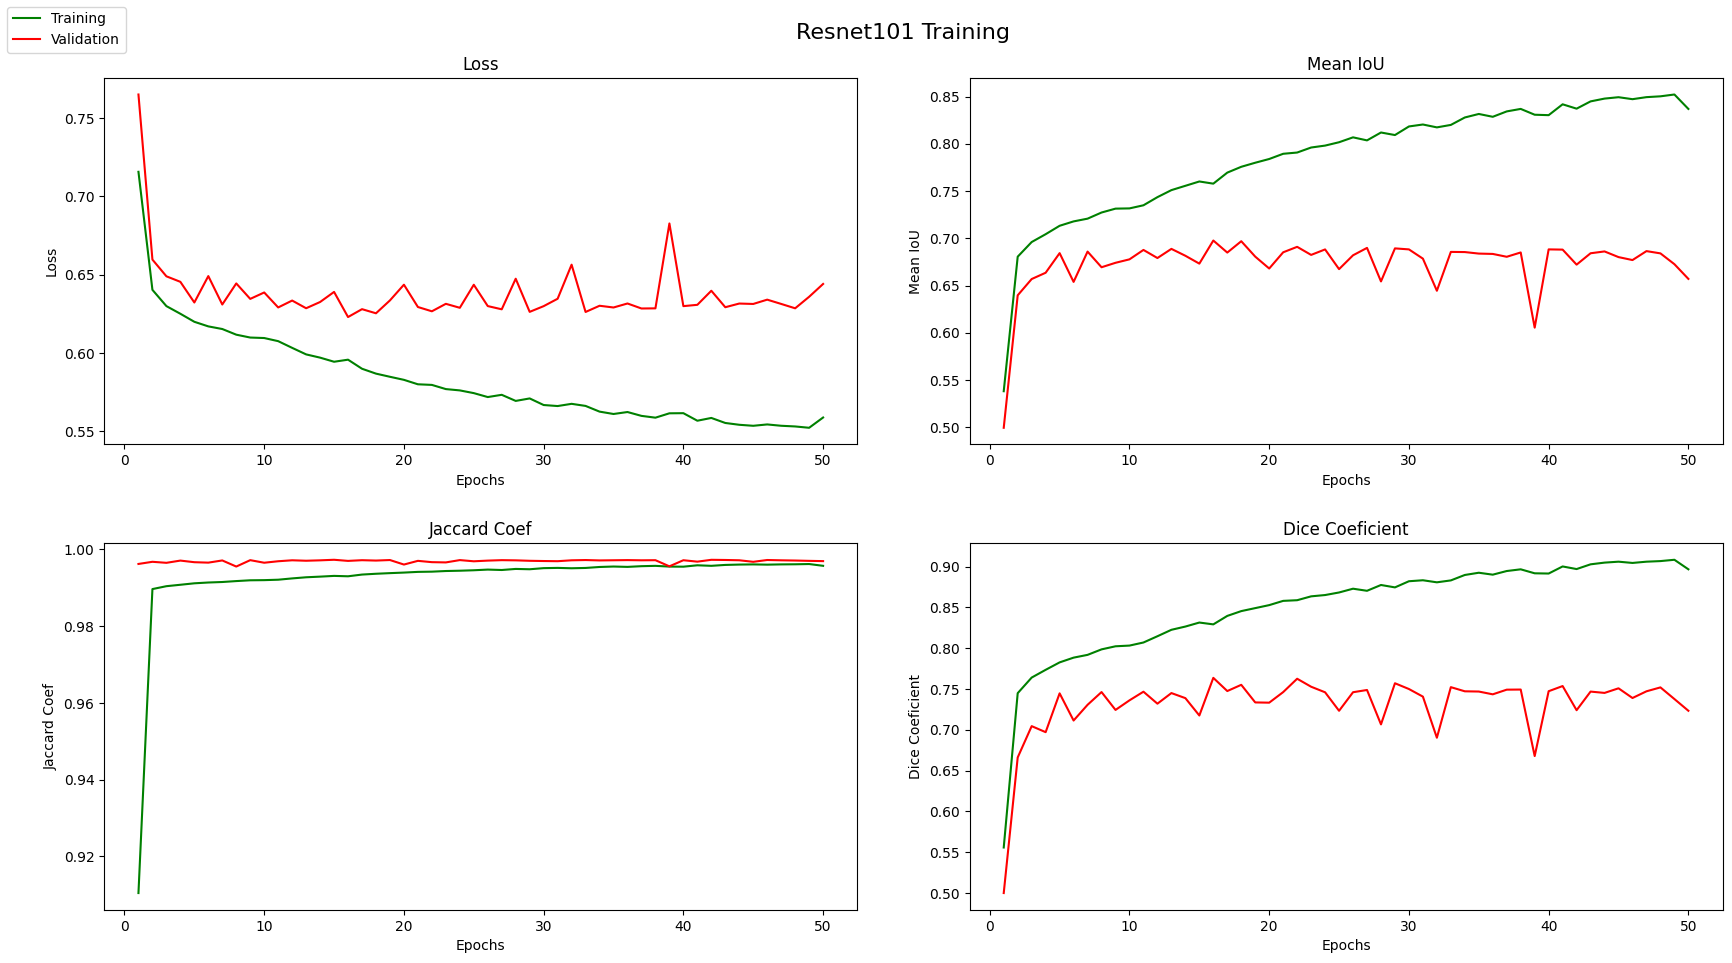

Model's last epoch's metrics:
loss = 0.5587
IOU score = 0.8288
Mean IOU = 0.8369
accuracy = 0.9980
jaccard_coef = 0.9957
Dice Coeficient = 0.8967
val_loss = 0.6440
val_IOU score = 0.6458
val_Mean IOU = 0.6570
val_accuracy = 0.9985
val_jaccard_coef = 0.9969
val_Dice Coeficient = 0.7233


In [15]:
# Plot Resnet101 Training History
model_name = "Baseline_Resnet101_Ash_Image_50_epochs"
with open(TRAIN_HISTORY_PATH + model_name + '_train_history.pkl', 'rb') as pfile:
    train_history = pickle.load(pfile)
visualize_train_curves(train_history, "Resnet101 Training")

In [ ]:
# Train DeeplabV3+ with Resnet50

BATCH_SIZE = 16
training_generator = DataGenerator(train_id_list, image_channels=3, batch_size=BATCH_SIZE, kaggle=False)
# test_generator = DataGenerator(test_id_list, image_channels=3, batch_size=1, shuffle=False, test=True, kaggle=True)
validation_generator = DataGenerator(validation_id_list, image_channels=3, batch_size=BATCH_SIZE, shuffle=True, test=False, kaggle=False)


input_shape = (256, 256, 3)
model = DeepLabV3Plus(input_shape)

model.compile(optimizer="adam", 
              loss=bce_dice_loss, 
              metrics=metrics)

model_name = "Baseline_DeepLabv3Plus_Ash_Image_50_epochs_BCE_Dice_Loss"


train_model(model, model_name, epochs=NUM_EPOCHS, models_path=MODELS_PATH, train_history_path=TRAIN_HISTORY_PATH)
   

Epoch 1/50


2023-07-12 02:07:43.802862: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:434] Loaded cuDNN version 8900
2023-07-12 02:07:53.887326: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f77123d8fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-12 02:07:53.887391: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-07-12 02:07:54.765831: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-12 02:07:57.032078: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1283/1283 [==============================] - 739s 526ms/step - loss: 0.0290 - IOU score: 0.5252 - Mean IOU: 0.5589 - accuracy: 0.9941 - jaccard_coef: 0.9874 - Dice Coeficient: 0.5507 - val_loss: 0.0085 - val_IOU score: 0.5181 - val_Mean IOU: 0.5603 - val_accuracy: 0.9983 - val_jaccard_coef: 0.9966 - val_Dice Coeficient: 0.5337
Epoch 2/50
1283/1283 [==============================] - 676s 525ms/step - loss: 0.0185 - IOU score: 0.5639 - Mean IOU: 0.6283 - accuracy: 0.9955 - jaccard_coef: 0.9903 - Dice Coeficient: 0.6140 - val_loss: 0.0420 - val_IOU score: 0.5325 - val_Mean IOU: 0.6097 - val_accuracy: 0.9984 - val_jaccard_coef: 0.9831 - val_Dice Coeficient: 0.5706
Epoch 3/50
1283/1283 [==============================] - 675s 525ms/step - loss: 0.0173 - IOU score: 0.5788 - Mean IOU: 0.6472 - accuracy: 0.9957 - jaccard_coef: 0.9907 - Dice Coeficient: 0.6366 - val_loss: 0.0083 - val_IOU score: 0.5323 - val_Mean IOU: 0.5801 - val_accuracy: 0.9984 - val_jaccard_coef: 0.9968 - val_Dice Coeficient

In [10]:
print('completed')

completed


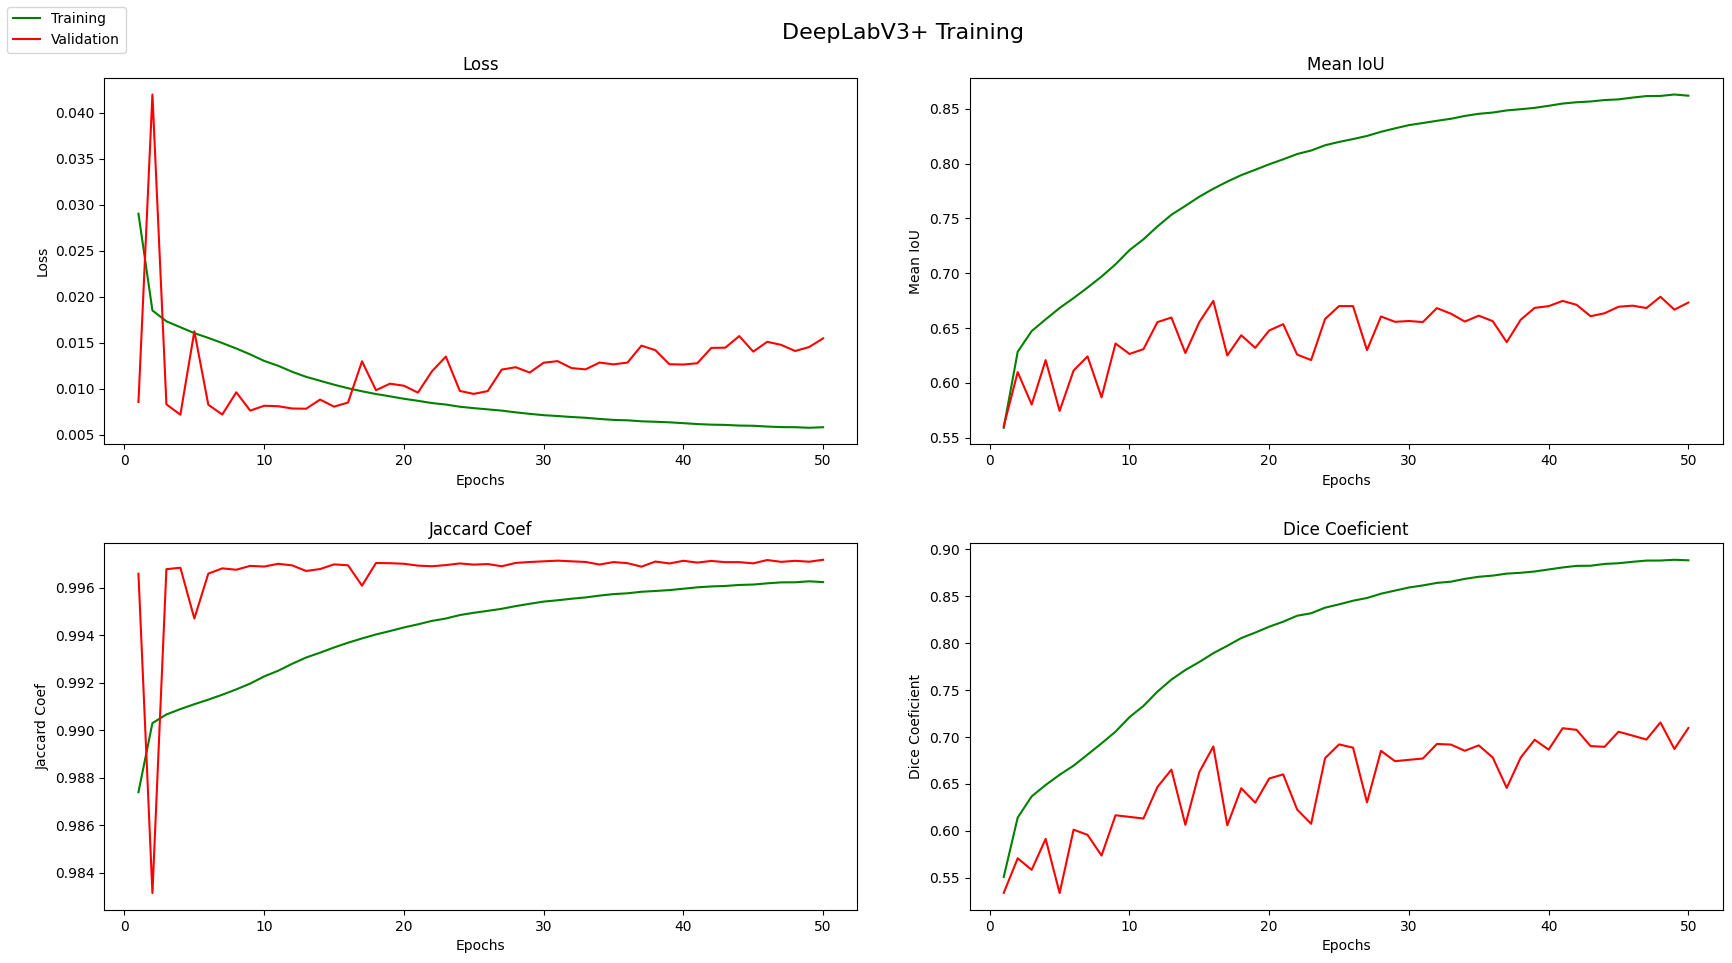

Model's last epoch's metrics:
loss = 0.006
IOU score = 0.818
Mean IOU = 0.862
accuracy = 0.998
jaccard_coef = 0.996
Dice Coeficient = 0.888
val_loss = 0.015
val_IOU score = 0.639
val_Mean IOU = 0.673
val_accuracy = 0.999
val_jaccard_coef = 0.997
val_Dice Coeficient = 0.710


In [11]:
# Plot DeeplabV3+ Training History
model_name = "Baseline_DeepLabv3Plus_Ash_Image_50_epochs_BCE_Dice_Loss"
with open(TRAIN_HISTORY_PATH + model_name + '_train_history.pkl', 'rb') as pfile:
    train_history = pickle.load(pfile)
visualize_train_curves(train_history, "DeepLabV3+ Training")

In [21]:
# Train UNet using all time-series images 
BATCH_SIZE = 32
IMAGE_CHANNELS = 9
# Loaders need to use 24 channels (RGB X 8 time-series images)
training_generator = DataGenerator(train_id_list, image_channels=IMAGE_CHANNELS, batch_size=BATCH_SIZE, kaggle=False, time_series=True)
# test_generator = DataGenerator(test_id_list, image_channels=24, batch_size=1, shuffle=False, test=True, kaggle=True, time_series=True)
validation_generator = DataGenerator(validation_id_list, image_channels=IMAGE_CHANNELS, batch_size=BATCH_SIZE, shuffle=True, test=False, kaggle=False, time_series=True)

# Train Unet Model 
model = multi_unet_model(image_channels=IMAGE_CHANNELS)

model.compile(optimizer="adam", 
              loss=total_loss, 
              metrics=metrics)

model_name = "Baseline_Unet_time_series_Ash_Image_50_epochs"


train_model(model, model_name, epochs=NUM_EPOCHS, models_path=MODELS_PATH, train_history_path=TRAIN_HISTORY_PATH)
    

Epoch 1/50


2023-07-12 18:11:55.109955: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:959] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


641/641 [==============================] - 623s 925ms/step - loss: 0.7471 - IOU score: 0.4865 - Mean IOU: 0.5375 - accuracy: 0.9919 - jaccard_coef: 0.9542 - Dice Coeficient: 0.5080 - val_loss: 0.7411 - val_IOU score: 0.5182 - val_Mean IOU: 0.5281 - val_accuracy: 0.9935 - val_jaccard_coef: 0.9828 - val_Dice Coeficient: 0.5421
Epoch 2/50
641/641 [==============================] - 601s 933ms/step - loss: 0.7059 - IOU score: 0.5597 - Mean IOU: 0.5901 - accuracy: 0.9926 - jaccard_coef: 0.9835 - Dice Coeficient: 0.6097 - val_loss: 0.7097 - val_IOU score: 0.5561 - val_Mean IOU: 0.5751 - val_accuracy: 0.9971 - val_jaccard_coef: 0.9929 - val_Dice Coeficient: 0.5995
Epoch 3/50
641/641 [==============================] - 602s 934ms/step - loss: 0.6778 - IOU score: 0.6031 - Mean IOU: 0.6277 - accuracy: 0.9938 - jaccard_coef: 0.9867 - Dice Coeficient: 0.6721 - val_loss: 0.6846 - val_IOU score: 0.5889 - val_Mean IOU: 0.6044 - val_accuracy: 0.9977 - val_jaccard_coef: 0.9950 - val_Dice Coeficient: 0.64

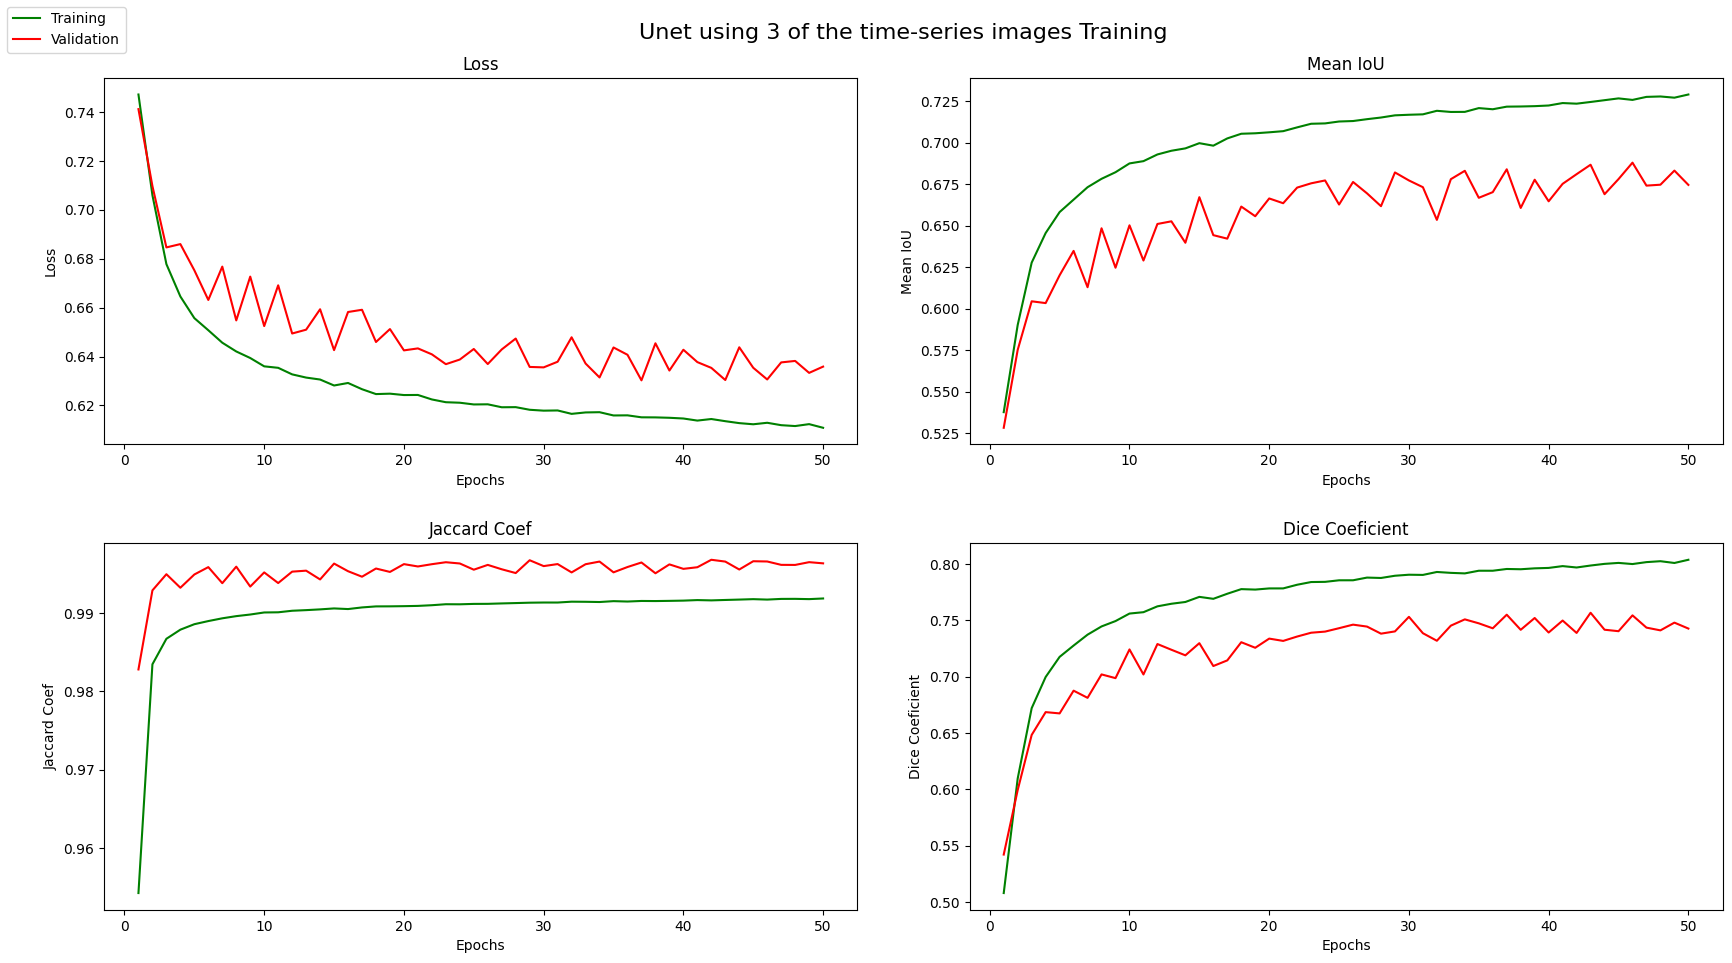

Model's last epoch's metrics:
loss = 0.6109
IOU score = 0.7179
Mean IOU = 0.7291
accuracy = 0.9961
jaccard_coef = 0.9919
Dice Coeficient = 0.8039
val_loss = 0.6359
val_IOU score = 0.6625
val_Mean IOU = 0.6746
val_accuracy = 0.9982
val_jaccard_coef = 0.9964
val_Dice Coeficient = 0.7428


In [22]:
# Plot Training History with Unet using 3 of the time-series images 
model_name = "Baseline_Unet_time_series_Ash_Image_50_epochs"
with open(TRAIN_HISTORY_PATH + model_name + '_train_history.pkl', 'rb') as pfile:
    train_history = pickle.load(pfile)
visualize_train_curves(train_history, "Unet using 3 of the time-series images Training")

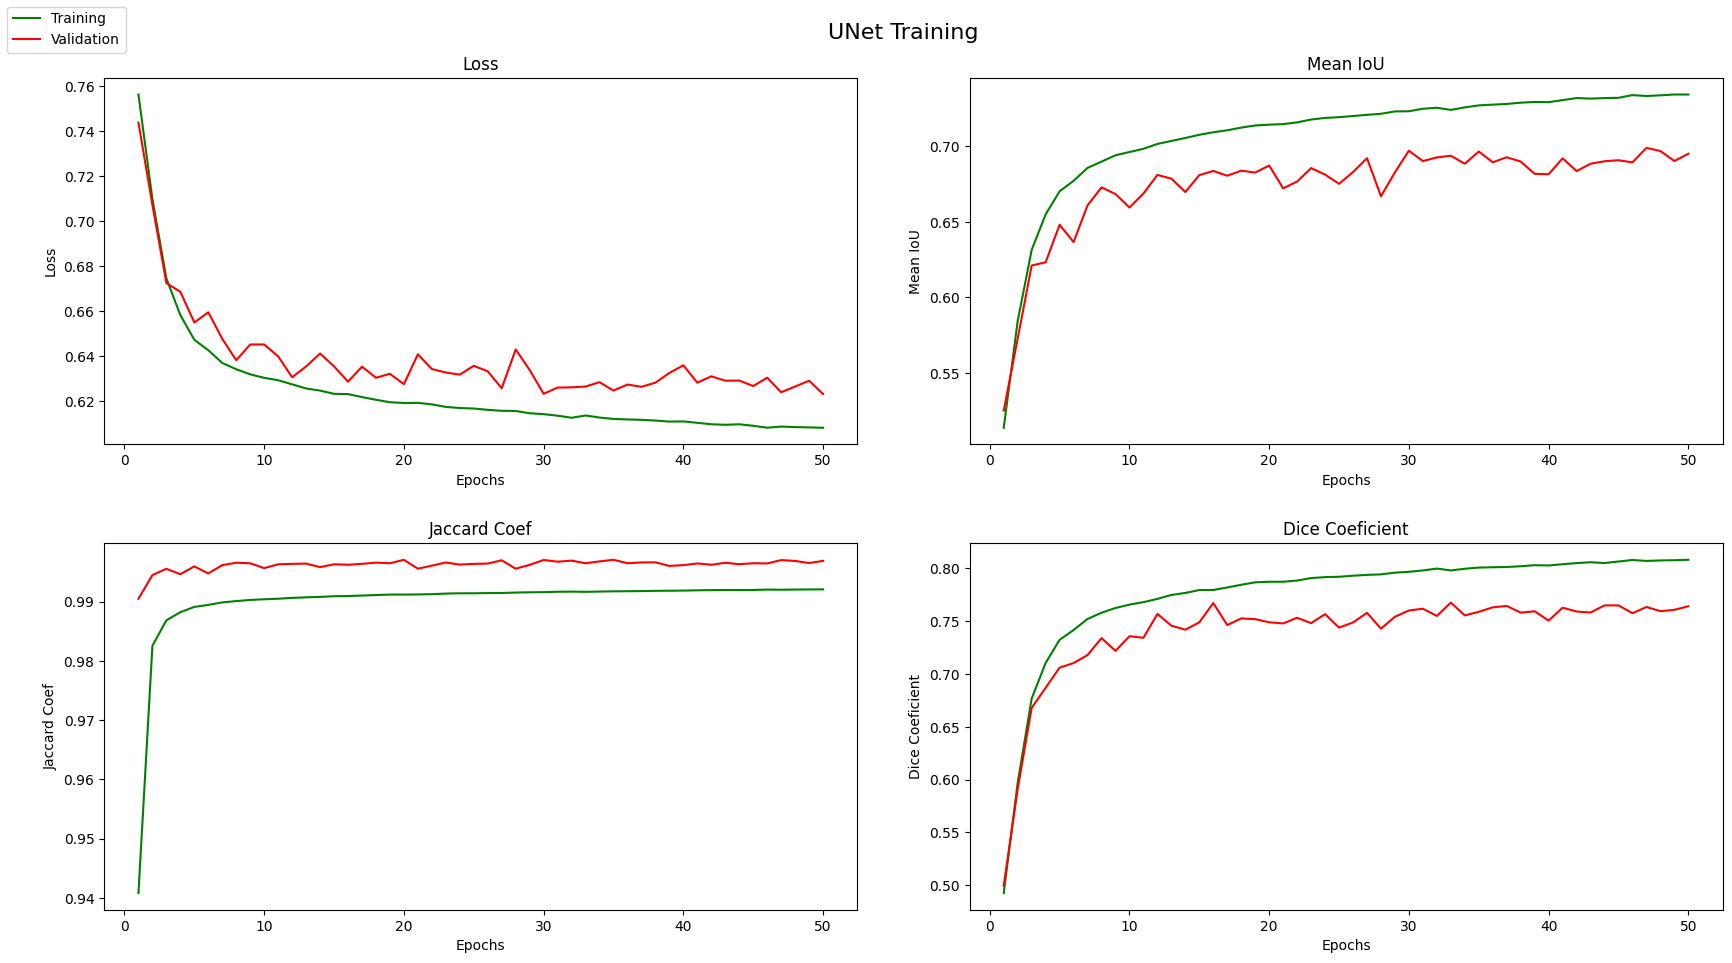

Model's last epoch's metrics:
loss = 0.6082
IOU score = 0.7224
Mean IOU = 0.7342
accuracy = 0.9962
jaccard_coef = 0.9921
Dice Coeficient = 0.8082
val_loss = 0.6232
val_IOU score = 0.6814
val_Mean IOU = 0.6951
val_accuracy = 0.9985
val_jaccard_coef = 0.9969
val_Dice Coeficient = 0.7642


In [17]:
# Plot Unet Training History
model_name = "Baseline_Unet_Ash_Image_50_epochs"
with open(TRAIN_HISTORY_PATH + model_name + '_train_history.pkl', 'rb') as pfile:
    train_history = pickle.load(pfile)
visualize_train_curves(train_history, "UNet Training")

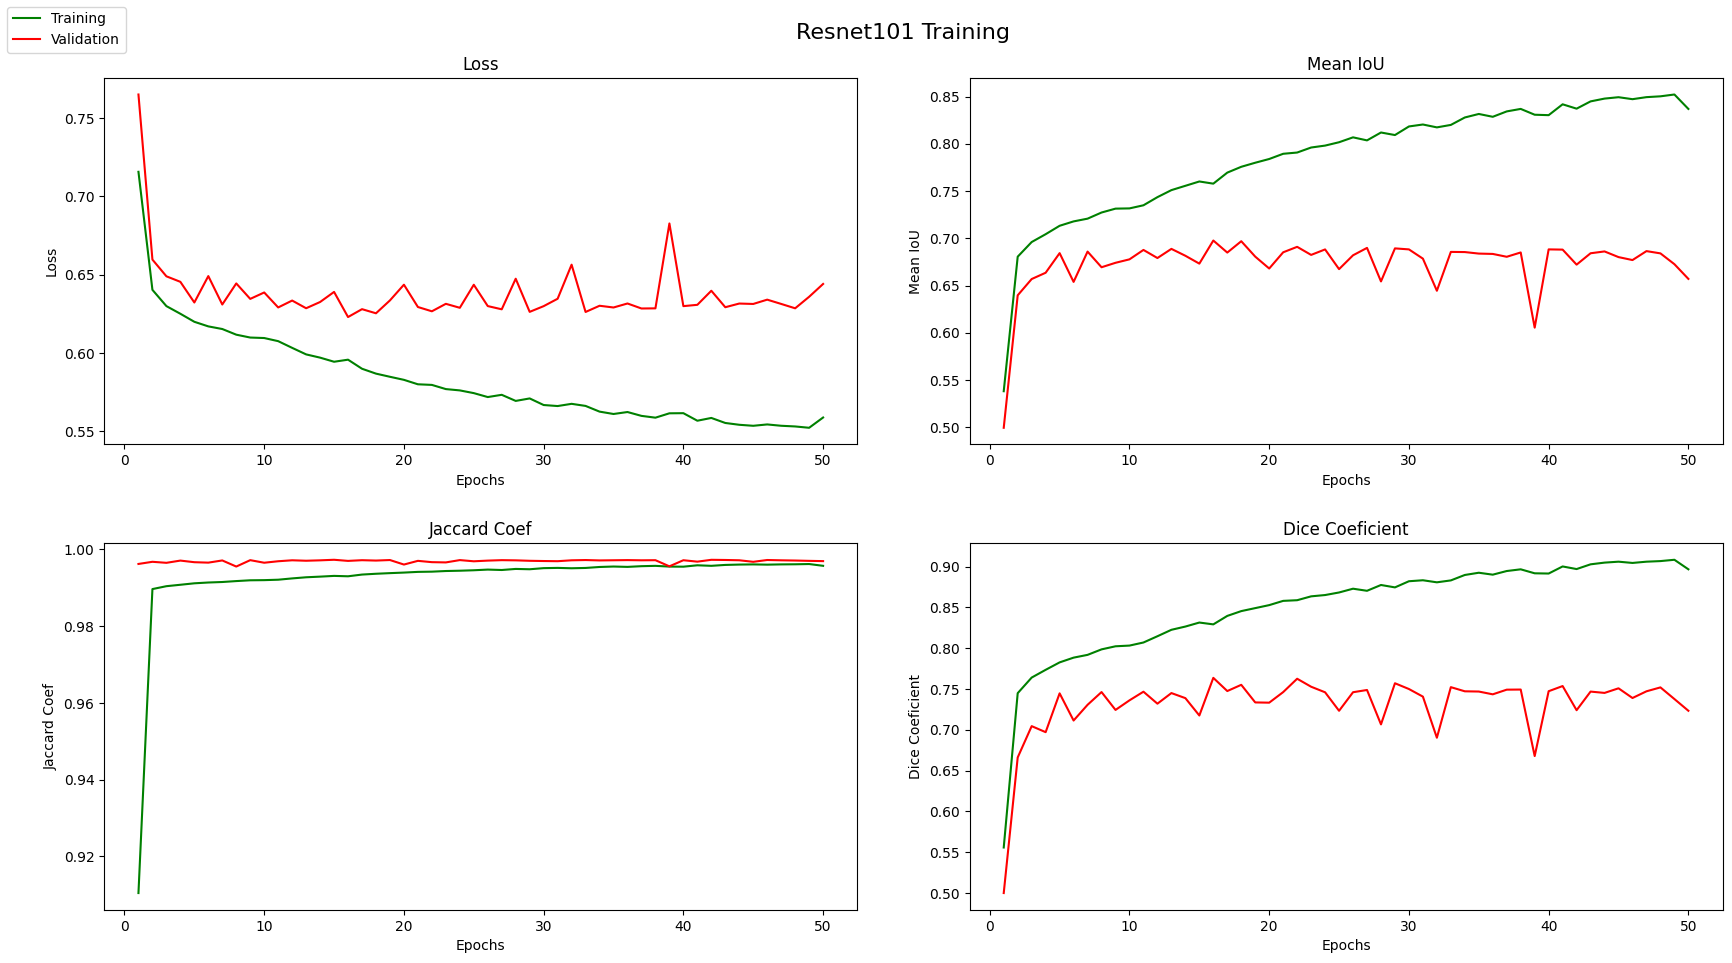

Model's last epoch's metrics:
loss = 0.5587
IOU score = 0.8288
Mean IOU = 0.8369
accuracy = 0.9980
jaccard_coef = 0.9957
Dice Coeficient = 0.8967
val_loss = 0.6440
val_IOU score = 0.6458
val_Mean IOU = 0.6570
val_accuracy = 0.9985
val_jaccard_coef = 0.9969
val_Dice Coeficient = 0.7233


In [19]:
# Plot Resnet101 Training History
model_name = "Baseline_Resnet101_Ash_Image_50_epochs"
with open(TRAIN_HISTORY_PATH + model_name + '_train_history.pkl', 'rb') as pfile:
    train_history = pickle.load(pfile)
visualize_train_curves(train_history, "Resnet101 Training")

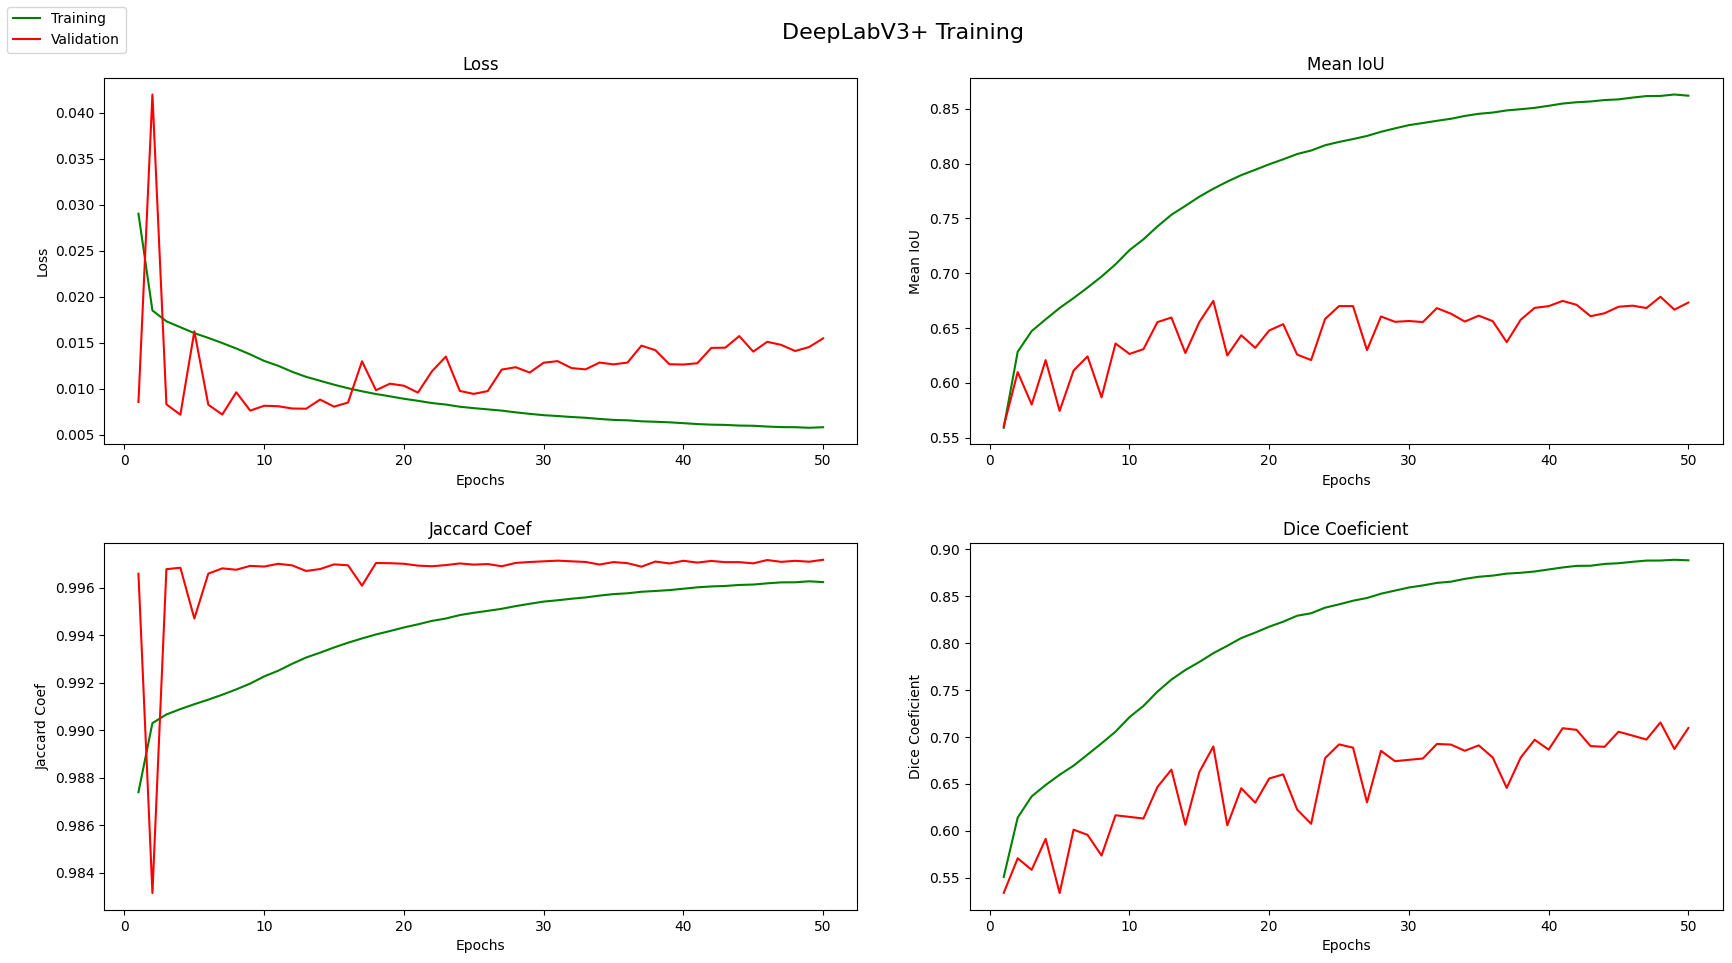

Model's last epoch's metrics:
loss = 0.0058
IOU score = 0.8182
Mean IOU = 0.8620
accuracy = 0.9983
jaccard_coef = 0.9962
Dice Coeficient = 0.8884
val_loss = 0.0155
val_IOU score = 0.6391
val_Mean IOU = 0.6732
val_accuracy = 0.9986
val_jaccard_coef = 0.9972
val_Dice Coeficient = 0.7095


In [20]:
# Plot DeeplabV3+ Training History
model_name = "Baseline_DeepLabv3Plus_Ash_Image_50_epochs_BCE_Dice_Loss"
with open(TRAIN_HISTORY_PATH + model_name + '_train_history.pkl', 'rb') as pfile:
    train_history = pickle.load(pfile)
visualize_train_curves(train_history, "DeepLabV3+ Training")


# TransUnet with different Learning rate

In [ ]:
# TransUnet model training with exponential decay learning rate
NUM_EPOCHS = 50
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
    name="Adam")

model = trans_unet_model()

model.compile(optimizer=optimizer, 
              loss=total_loss, 
              metrics=metrics)

model_name = "Trans_Unet_w_lr_decay_50_epochs"

train_model(model, model_name, epochs=NUM_EPOCHS, models_path=MODELS_PATH, train_history_path=TRAIN_HISTORY_PATH)
  

Epoch 1/50


2023-07-13 03:41:31.281984: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:959] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout_14/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


641/641 [==============================] - 714s 924ms/step - loss: 0.7525 - IOU score: 0.4852 - Mean IOU: 0.5276 - accuracy: 0.9930 - jaccard_coef: 0.9438 - Dice Coeficient: 0.5047 - val_loss: 0.7310 - val_IOU score: 0.5168 - val_Mean IOU: 0.5419 - val_accuracy: 0.9979 - val_jaccard_coef: 0.9945 - val_Dice Coeficient: 0.5330
Epoch 2/50
641/641 [==============================] - 602s 935ms/step - loss: 0.6883 - IOU score: 0.5893 - Mean IOU: 0.6133 - accuracy: 0.9936 - jaccard_coef: 0.9860 - Dice Coeficient: 0.6527 - val_loss: 0.6864 - val_IOU score: 0.5825 - val_Mean IOU: 0.6020 - val_accuracy: 0.9977 - val_jaccard_coef: 0.9948 - val_Dice Coeficient: 0.6404
Epoch 3/50
641/641 [==============================] - 602s 935ms/step - loss: 0.6627 - IOU score: 0.6277 - Mean IOU: 0.6490 - accuracy: 0.9945 - jaccard_coef: 0.9882 - Dice Coeficient: 0.7044 - val_loss: 0.6687 - val_IOU score: 0.6118 - val_Mean IOU: 0.6274 - val_accuracy: 0.9979 - val_jaccard_coef: 0.9954 - val_Dice Coeficient: 0.68

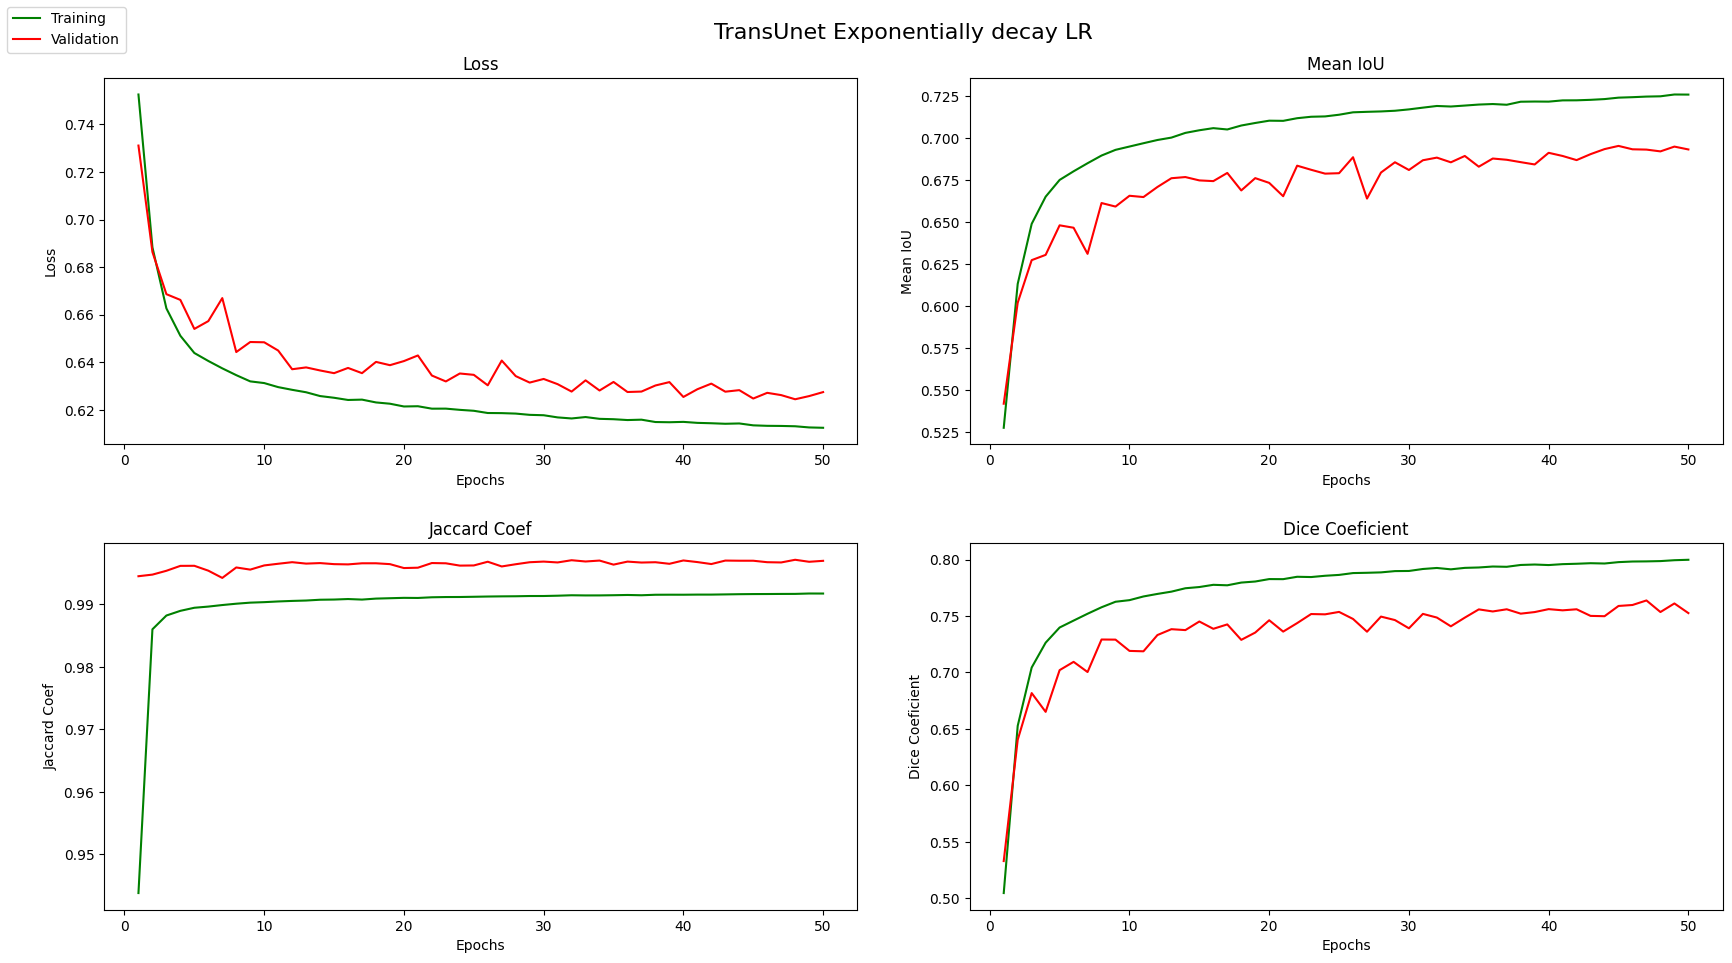

Model's last epoch's metrics:
loss = 0.6126
IOU score = 0.7138
Mean IOU = 0.7260
accuracy = 0.9960
jaccard_coef = 0.9917
Dice Coeficient = 0.7998
val_loss = 0.6275
val_IOU score = 0.6710
val_Mean IOU = 0.6933
val_accuracy = 0.9986
val_jaccard_coef = 0.9970
val_Dice Coeficient = 0.7526


In [35]:
# Plot TransUnet Exponentially decay LR
model_name = "Trans_Unet_w_lr_decay_50_epochs"
with open(TRAIN_HISTORY_PATH + model_name + '_train_history.pkl', 'rb') as pfile:
    train_history = pickle.load(pfile)
visualize_train_curves(train_history, "TransUnet Exponentially decay LR")

In [ ]:
# TransUnet model training with exponential decay learning rate 641 batches per epoch
model_name = "Trans_Unet_w_lr_decay_50_epochs"

NUM_EPOCHS = 50
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=641,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
    name="Adam")

model = trans_unet_model()

model.compile(optimizer=optimizer, 
              loss=total_loss, 
              metrics=metrics)



train_model(model, model_name, epochs=NUM_EPOCHS, models_path=MODELS_PATH, train_history_path=TRAIN_HISTORY_PATH)
  

Epoch 1/50


2023-07-13 17:50:07.296578: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:959] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-07-13 17:50:24.301436: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:434] Loaded cuDNN version 8900
2023-07-13 17:50:33.484706: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55f0c5b75ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-13 17:50:33.484756: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-07-13 17:50:34.194690: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-13 17:50:36.324060: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using X

641/641 [==============================] - 690s 926ms/step - loss: 0.7534 - IOU score: 0.4756 - Mean IOU: 0.5256 - accuracy: 0.9933 - jaccard_coef: 0.9441 - Dice Coeficient: 0.4894 - val_loss: 0.7406 - val_IOU score: 0.4993 - val_Mean IOU: 0.5299 - val_accuracy: 0.9953 - val_jaccard_coef: 0.9862 - val_Dice Coeficient: 0.5068
Epoch 2/50
641/641 [==============================] - 600s 931ms/step - loss: 0.6942 - IOU score: 0.5776 - Mean IOU: 0.6054 - accuracy: 0.9932 - jaccard_coef: 0.9849 - Dice Coeficient: 0.6360 - val_loss: 0.6904 - val_IOU score: 0.5870 - val_Mean IOU: 0.6013 - val_accuracy: 0.9976 - val_jaccard_coef: 0.9945 - val_Dice Coeficient: 0.6447
Epoch 3/50
641/641 [==============================] - 600s 931ms/step - loss: 0.6665 - IOU score: 0.6210 - Mean IOU: 0.6435 - accuracy: 0.9943 - jaccard_coef: 0.9877 - Dice Coeficient: 0.6957 - val_loss: 0.6752 - val_IOU score: 0.5991 - val_Mean IOU: 0.6192 - val_accuracy: 0.9978 - val_jaccard_coef: 0.9954 - val_Dice Coeficient: 0.66

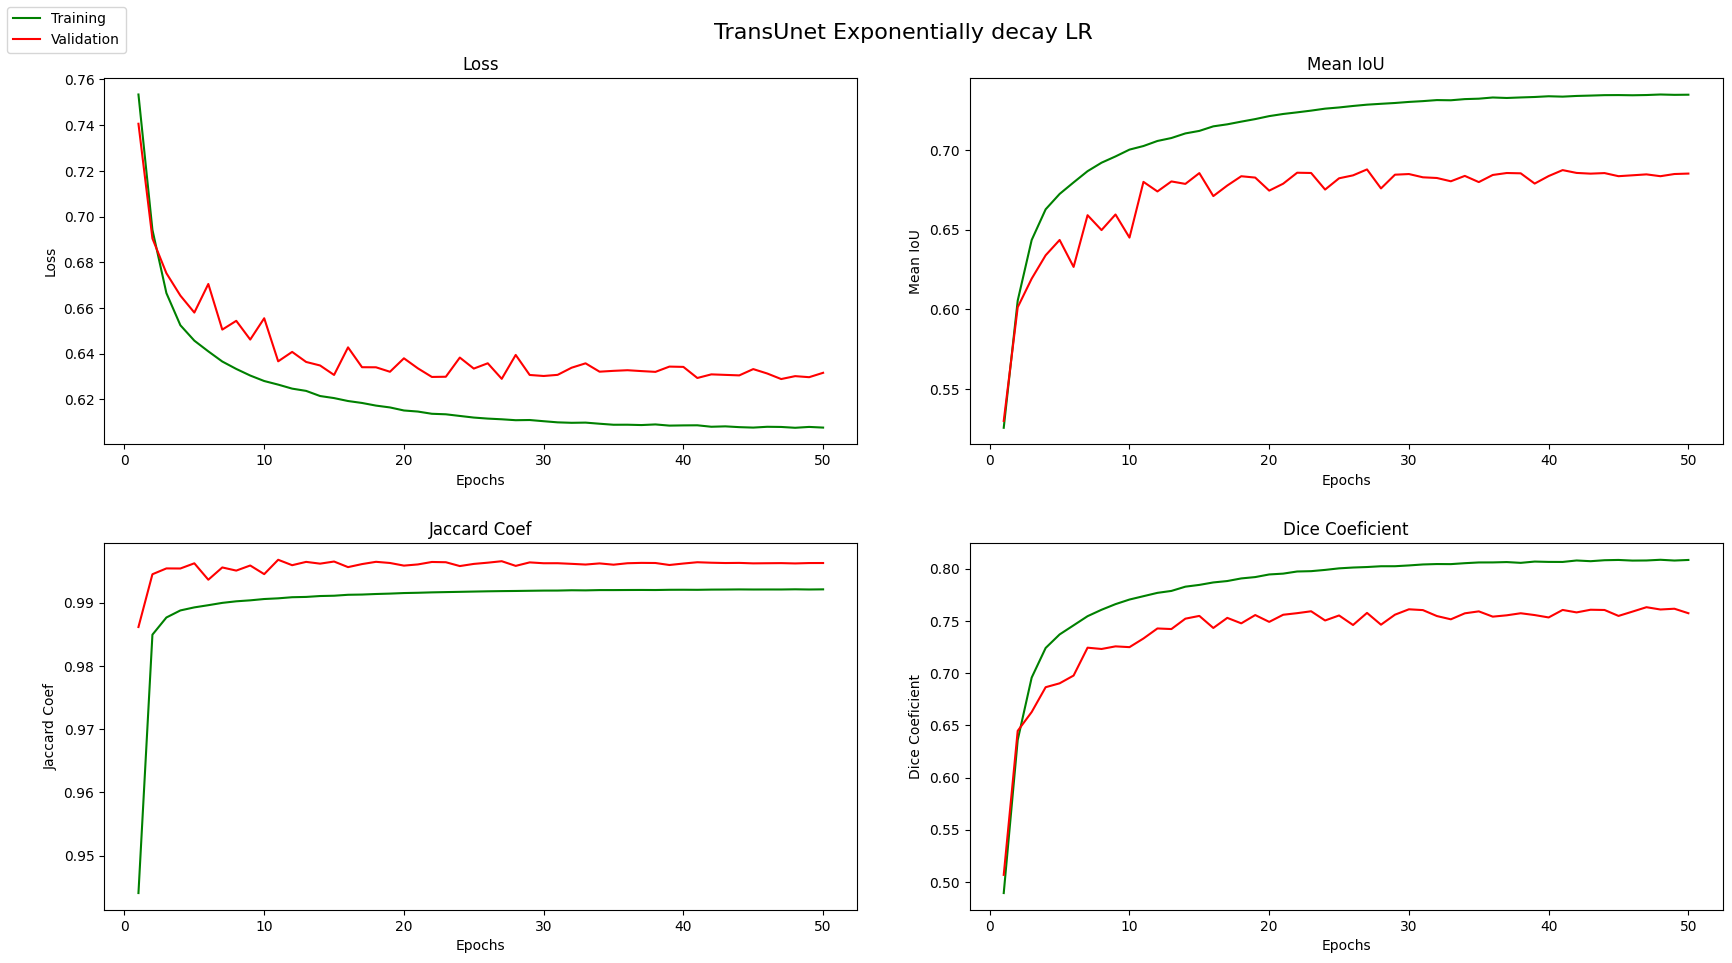

Model's last epoch's metrics:
loss = 0.6076
IOU score = 0.7227
Mean IOU = 0.7348
accuracy = 0.9962
jaccard_coef = 0.9921
Dice Coeficient = 0.8084
val_loss = 0.6316
val_IOU score = 0.6750
val_Mean IOU = 0.6853
val_accuracy = 0.9982
val_jaccard_coef = 0.9963
val_Dice Coeficient = 0.7574


In [11]:
# Plot TransUnet Exponentially decay LR
model_name = "Trans_Unet_w_lr_decay_50_epochs"
with open(TRAIN_HISTORY_PATH + model_name + '_train_history.pkl', 'rb') as pfile:
    train_history = pickle.load(pfile)
visualize_train_curves(train_history, "TransUnet Exponentially decay LR")

# Training with 6 channels images 

In [5]:
# Train model using 6 channels as Ziling found documentation about it
NUM_EPOCHS = 50
IMAGE_CHANNELS = 6

# Data generator using 6 channels and kaggle flag to generate the images on the fly
training_generator = DataGenerator(train_id_list, image_channels=IMAGE_CHANNELS, batch_size=BATCH_SIZE, multiple_bands = True, kaggle=True,)
validation_generator = DataGenerator(validation_id_list, image_channels=IMAGE_CHANNELS, batch_size=BATCH_SIZE, shuffle=True, test=False, multiple_bands = True, kaggle=True,)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=641,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
    name="Adam")

# Train Unet Model 
model = multi_unet_model(image_channels=IMAGE_CHANNELS)
model.compile(optimizer=optimizer, 
              loss=total_loss, 
              metrics=metrics)

model_name = "Baseline_Unet_6_channels_Images_50_epochs"

train_model(model, model_name, epochs=NUM_EPOCHS,  models_path=MODELS_PATH, train_history_path=TRAIN_HISTORY_PATH)
    

Epoch 1/50


2023-07-14 15:47:45.181656: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:959] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-07-14 15:47:57.763137: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:434] Loaded cuDNN version 8900
2023-07-14 15:48:07.439576: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f048f835510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-14 15:48:07.439624: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-07-14 15:48:08.068341: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-14 15:48:10.341232: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using X

641/641 [==============================] - 813s 1s/step - loss: 0.7565 - real_dice_coeff: 0.9714 - Mean IOU: 0.5177 - accuracy: 0.9927 - jaccard_coef: 0.9455 - Dice Coeficient: 0.5206 - val_loss: 0.7493 - val_real_dice_coeff: 0.9908 - val_Mean IOU: 0.5175 - val_accuracy: 0.9946 - val_jaccard_coef: 0.9818 - val_Dice Coeficient: 0.5330
Epoch 2/50
641/641 [==============================] - 793s 1s/step - loss: 0.7224 - real_dice_coeff: 0.9910 - Mean IOU: 0.5700 - accuracy: 0.9924 - jaccard_coef: 0.9822 - Dice Coeficient: 0.6162 - val_loss: 0.7259 - val_real_dice_coeff: 0.9970 - val_Mean IOU: 0.5508 - val_accuracy: 0.9975 - val_jaccard_coef: 0.9940 - val_Dice Coeficient: 0.5809
Epoch 3/50
641/641 [==============================] - 795s 1s/step - loss: 0.7023 - real_dice_coeff: 0.9925 - Mean IOU: 0.5945 - accuracy: 0.9932 - jaccard_coef: 0.9850 - Dice Coeficient: 0.6534 - val_loss: 0.7109 - val_real_dice_coeff: 0.9968 - val_Mean IOU: 0.5671 - val_accuracy: 0.9972 - val_jaccard_coef: 0.9936 

FileNotFoundError: [Errno 2] No such file or directory: './models/Baseline_Unet_6_channels_Images_50_epochs.keras'

In [13]:
# Train model using 7 channels RGB from ash plus bands as Ziling found documentation 
NUM_EPOCHS = 50
IMAGE_CHANNELS = 7

# Data generator using 7 channels and kaggle flag to generate the images on the fly
training_generator = DataGenerator(train_id_list, image_channels=IMAGE_CHANNELS, batch_size=BATCH_SIZE, multiple_bands = True, kaggle=True,)
validation_generator = DataGenerator(validation_id_list, image_channels=IMAGE_CHANNELS, batch_size=BATCH_SIZE, shuffle=True, test=False, multiple_bands = True, kaggle=True,)


lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.005,
    decay_steps=len(train_id_list)//BATCH_SIZE,
    decay_rate=0.92)


        
lr_tracker = LearningRateTracker()

optimizer = tf.keras.optimizers.AdamW(
    learning_rate=lr_schedule,
    name="AdamW")

# Train Unet Model 
model = multi_unet_model(image_channels=IMAGE_CHANNELS)
model.compile(optimizer=optimizer, 
              loss=bce_dice_loss, 
              metrics=metrics)

model_name = "Unet_7_channels_Images_50_epochs_AdamW_decay_rate95"

train_model(model, model_name, epochs=NUM_EPOCHS,  models_path=MODELS_PATH, train_history_path=TRAIN_HISTORY_PATH)
    

Epoch 1/50


2023-07-15 07:38:33.431909: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:959] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_54/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


641/641 [==============================] - ETA: 0s - loss: 1.3754 - real_dice_coeff: 0.9934 - Mean IOU: 0.4973 - accuracy: 0.9944 - jaccard_coef: 0.9873 - Dice Coeficient: 0.4983
Epoch 1: Learning rate is 0.0046.
641/641 [==============================] - 808s 1s/step - loss: 1.3754 - real_dice_coeff: 0.9934 - Mean IOU: 0.4973 - accuracy: 0.9944 - jaccard_coef: 0.9873 - Dice Coeficient: 0.4983 - val_loss: 0.7628 - val_real_dice_coeff: 0.9981 - val_Mean IOU: 0.4991 - val_accuracy: 0.9982 - val_jaccard_coef: 0.9963 - val_Dice Coeficient: 0.4995
Epoch 2/50
641/641 [==============================] - ETA: 0s - loss: 0.8252 - real_dice_coeff: 0.9945 - Mean IOU: 0.4973 - accuracy: 0.9947 - jaccard_coef: 0.9890 - Dice Coeficient: 0.4987
Epoch 2: Learning rate is 0.0042.
641/641 [==============================] - 794s 1s/step - loss: 0.8252 - real_dice_coeff: 0.9945 - Mean IOU: 0.4973 - accuracy: 0.9947 - jaccard_coef: 0.9890 - Dice Coeficient: 0.4987 - val_loss: 0.7653 - val_real_dice_coeff: 0

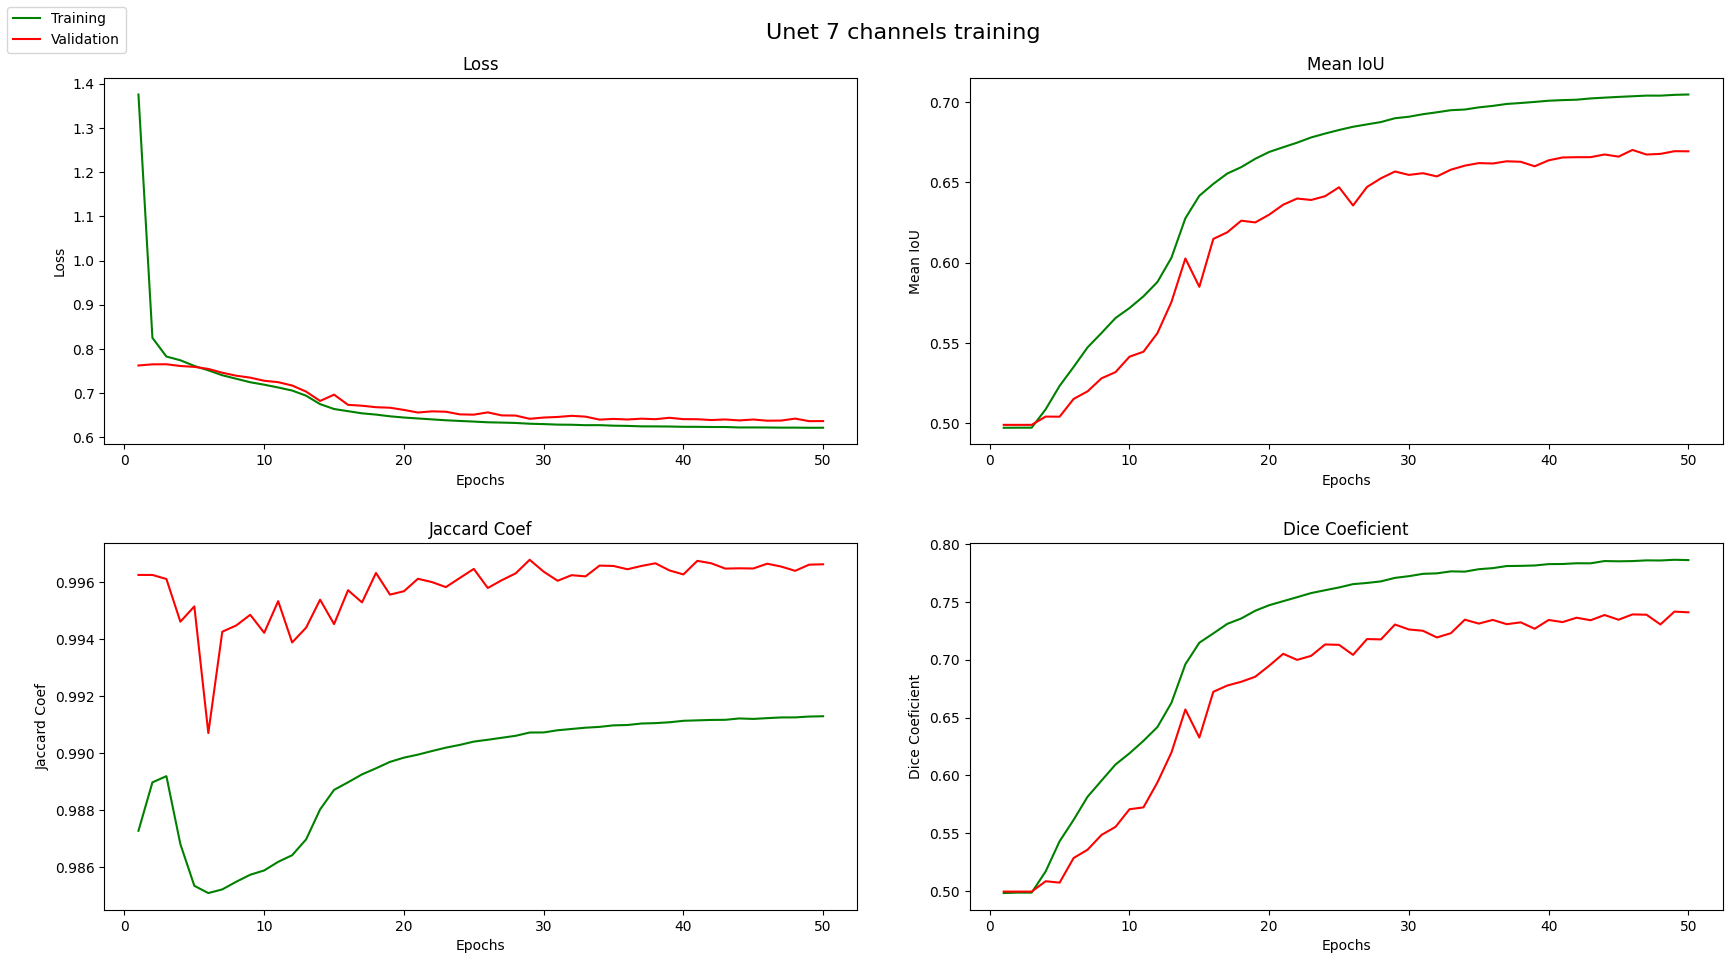

Model's last epoch's metrics:
loss = 0.6220
real_dice_coeff = 0.9956
Mean IOU = 0.7046
accuracy = 0.9957
jaccard_coef = 0.9913
Dice Coeficient = 0.7861
val_loss = 0.6371
val_real_dice_coeff = 0.9983
val_Mean IOU = 0.6693
val_accuracy = 0.9983
val_jaccard_coef = 0.9966
val_Dice Coeficient = 0.7410


In [15]:
# Plot model trained with 7 channels images
model_name = "Unet_7_channels_Images_50_epochs_AdamW_decay_rate95"
with open(TRAIN_HISTORY_PATH + model_name + '_train_history.pkl', 'rb') as pfile:
    train_history = pickle.load(pfile)
visualize_train_curves(train_history, "Unet 7 channels training")

In [16]:
NUM_EPOCHS = 30
IMAGE_CHANNELS = 7

# Data generator using 7 channels and kaggle flag to generate the images on the fly
# training_generator = DataGenerator(train_id_list, image_channels=IMAGE_CHANNELS, batch_size=BATCH_SIZE, multiple_bands = True, kaggle=True,)
# validation_generator = DataGenerator(validation_id_list, image_channels=IMAGE_CHANNELS, batch_size=BATCH_SIZE, shuffle=True, test=False, multiple_bands = True, kaggle=True,)


lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0002,
    decay_steps=len(train_id_list)//BATCH_SIZE,
    decay_rate=0.95)



        
lr_tracker = LearningRateTracker()

optimizer = tf.keras.optimizers.AdamW(
    learning_rate=lr_schedule,
    name="AdamW")

# Train Unet Model 
model = multi_unet_model(image_channels=IMAGE_CHANNELS)
model.compile(optimizer=optimizer, 
              loss=bce_dice_loss, 
              metrics=metrics)

model_name = "Unet_7_channels_Images_30_additional_epochs_AdamW_decay_rate95"

train_model(model, model_name, epochs=NUM_EPOCHS,  models_path=MODELS_PATH, train_history_path=TRAIN_HISTORY_PATH)

Epoch 1/30


2023-07-15 18:52:19.937923: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:959] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/dropout_63/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


641/641 [==============================] - ETA: 0s - loss: 0.7997 - real_dice_coeff: 0.9887 - Mean IOU: 0.5010 - accuracy: 0.9907 - jaccard_coef: 0.9804 - Dice Coeficient: 0.4962
Epoch 1: Learning rate is 0.0002.
641/641 [==============================] - 808s 1s/step - loss: 0.7997 - real_dice_coeff: 0.9887 - Mean IOU: 0.5010 - accuracy: 0.9907 - jaccard_coef: 0.9804 - Dice Coeficient: 0.4962 - val_loss: 0.7918 - val_real_dice_coeff: 0.9952 - val_Mean IOU: 0.4991 - val_accuracy: 0.9982 - val_jaccard_coef: 0.9905 - val_Dice Coeficient: 0.4995
Epoch 2/30
641/641 [==============================] - ETA: 0s - loss: 0.7733 - real_dice_coeff: 0.9930 - Mean IOU: 0.5109 - accuracy: 0.9936 - jaccard_coef: 0.9860 - Dice Coeficient: 0.5152
Epoch 2: Learning rate is 0.0002.
641/641 [==============================] - 803s 1s/step - loss: 0.7733 - real_dice_coeff: 0.9930 - Mean IOU: 0.5109 - accuracy: 0.9936 - jaccard_coef: 0.9860 - Dice Coeficient: 0.5152 - val_loss: 0.7649 - val_real_dice_coeff: 0

In [ ]:
NUM_EPOCHS = 50
IMAGE_CHANNELS = 7

# Data generator using 7 channels and kaggle flag to generate the images on the fly
training_generator = DataGenerator(train_id_list, image_channels=IMAGE_CHANNELS, batch_size=BATCH_SIZE, multiple_bands = True, kaggle=True,)
validation_generator = DataGenerator(validation_id_list, image_channels=IMAGE_CHANNELS, batch_size=BATCH_SIZE, shuffle=True, test=False, multiple_bands = True, kaggle=True,)


# Train Unet Model 
model = multi_unet_model(image_channels=IMAGE_CHANNELS)
model.compile(optimizer="adam", 
              loss=total_loss, 
              metrics=metrics)

model_name = "Unet_7_channels_total_loss_50_epochs"

train_model(model, model_name, epochs=NUM_EPOCHS,  models_path=MODELS_PATH, train_history_path=TRAIN_HISTORY_PATH)

Epoch 1/50


2023-07-16 06:15:40.161663: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:959] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-07-16 06:15:52.439986: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:434] Loaded cuDNN version 8900
2023-07-16 06:16:02.131416: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ff5b8004870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-16 06:16:02.131459: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-07-16 06:16:02.833672: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-16 06:16:04.653244: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using X

462/641 [====================>.........] - ETA: 3:14 - loss: 0.7636 - real_dice_coeff: 0.9578 - Mean IOU: 0.4973 - accuracy: 0.9908 - jaccard_coef: 0.9224 - Dice Coeficient: 0.4953

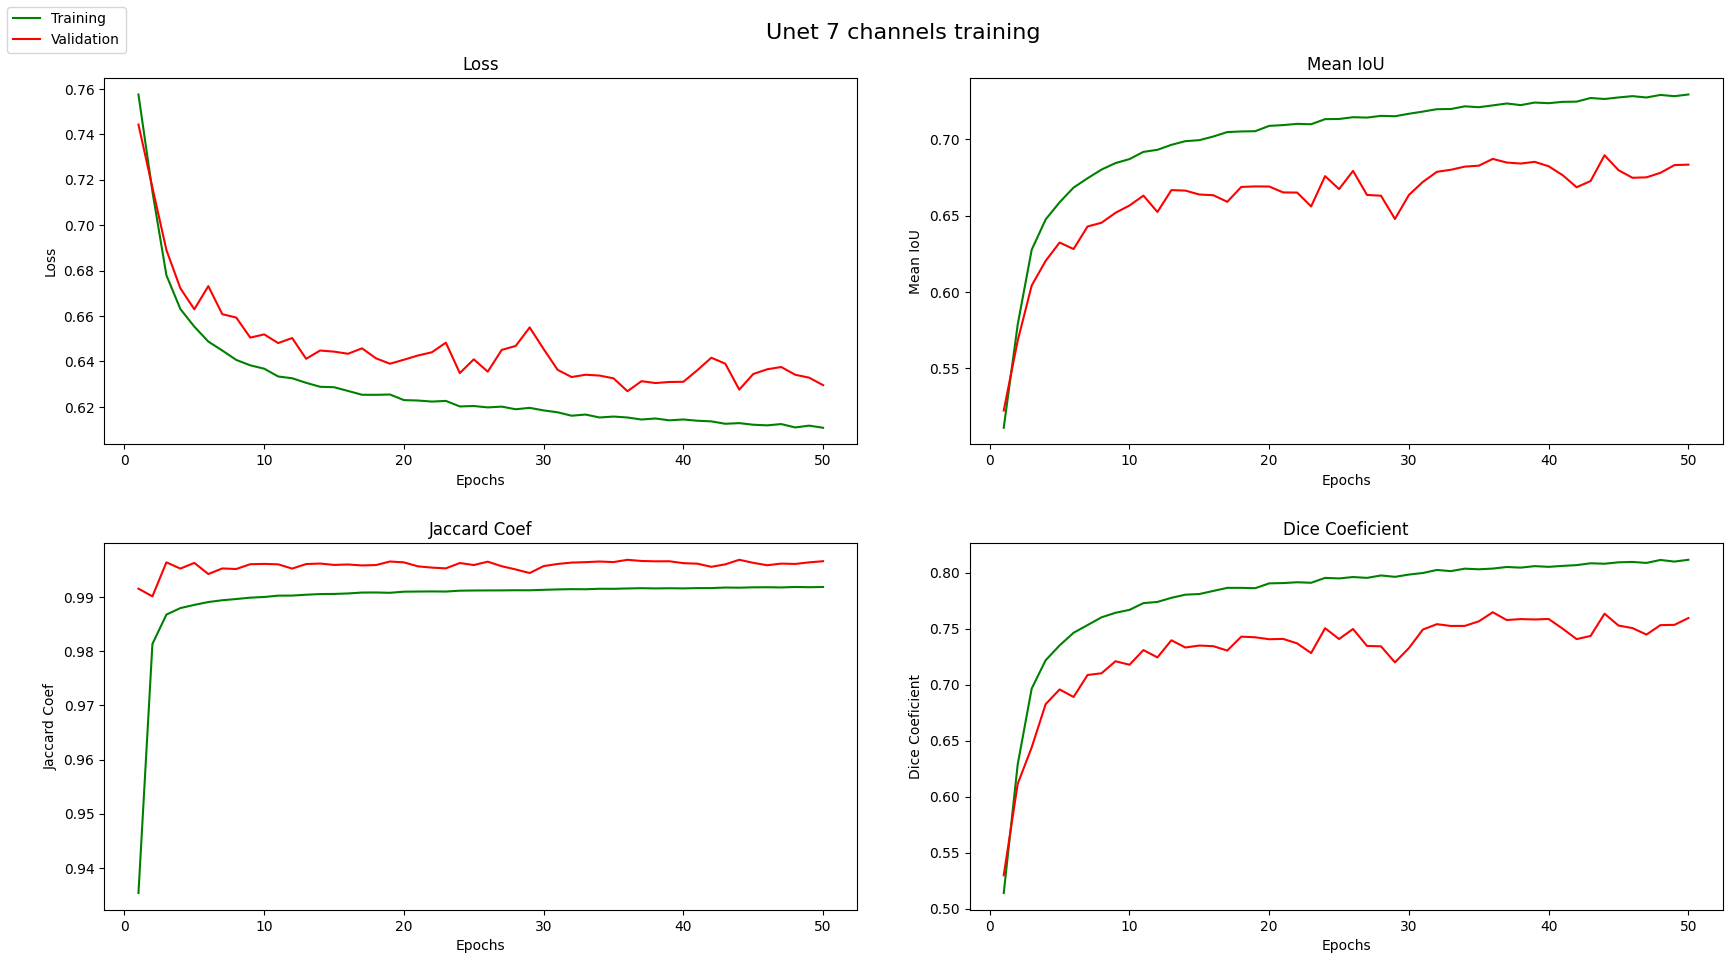

Model's last epoch's metrics:
loss = 0.6108
real_dice_coeff = 0.9959
Mean IOU = 0.7292
accuracy = 0.9961
jaccard_coef = 0.9919
Dice Coeficient = 0.8116
val_loss = 0.6296
val_real_dice_coeff = 0.9983
val_Mean IOU = 0.6833
val_accuracy = 0.9984
val_jaccard_coef = 0.9966
val_Dice Coeficient = 0.7595


In [11]:
# Plot model trained with 7 channels images
model_name = "Unet_7_channels_total_loss_50_epochs"
with open(TRAIN_HISTORY_PATH + model_name + '_train_history.pkl', 'rb') as pfile:
    train_history = pickle.load(pfile)
visualize_train_curves(train_history, "Unet 7 channels training")

In [10]:
print('done')

done


# Testing with Dice coefficient and BCE loss

In [14]:
NUM_EPOCHS = 25


dice_metrics = [real_dice_coeff, tf.keras.metrics.MeanIoU(num_classes=2, sparse_y_true= False, sparse_y_pred=False, name="Mean IOU"), "accuracy", jaccard_coef, sm.metrics.FScore(threshold=0.9, name="Dice Coeficient")]

lr_decay_optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
    name="Adam")

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=641,
    decay_rate=0.8)


In [ ]:
NUM_EPOCHS = 25

model_name = "Unet_BCE_Dice_loss_real_dice_metric"

model = multi_unet_model()

model.compile(optimizer=lr_decay_optimizer, 
              loss=bce_dice_loss, 
              metrics=dice_metrics)


train_model(model, model_name, epochs=NUM_EPOCHS, models_path=MODELS_PATH, train_history_path=TRAIN_HISTORY_PATH)
  

Epoch 1/25


2023-07-14 02:34:11.118280: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:959] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


641/641 [==============================] - 611s 921ms/step - loss: 0.7821 - real_dice_coeff: 0.9926 - Mean IOU: 0.5007 - accuracy: 0.9935 - jaccard_coef: 0.9859 - Dice Coeficient: 0.4972 - val_loss: 0.7625 - val_real_dice_coeff: 0.9927 - val_Mean IOU: 0.5141 - val_accuracy: 0.9943 - val_jaccard_coef: 0.9855 - val_Dice Coeficient: 0.4997
Epoch 2/25
641/641 [==============================] - 601s 934ms/step - loss: 0.7247 - real_dice_coeff: 0.9923 - Mean IOU: 0.5676 - accuracy: 0.9928 - jaccard_coef: 0.9847 - Dice Coeficient: 0.5905 - val_loss: 0.7230 - val_real_dice_coeff: 0.9971 - val_Mean IOU: 0.5486 - val_accuracy: 0.9972 - val_jaccard_coef: 0.9943 - val_Dice Coeficient: 0.5717
Epoch 3/25
641/641 [==============================] - 601s 933ms/step - loss: 0.6879 - real_dice_coeff: 0.9935 - Mean IOU: 0.6113 - accuracy: 0.9937 - jaccard_coef: 0.9871 - Dice Coeficient: 0.6638 - val_loss: 0.6953 - val_real_dice_coeff: 0.9970 - val_Mean IOU: 0.5863 - val_accuracy: 0.9970 - val_jaccard_coef

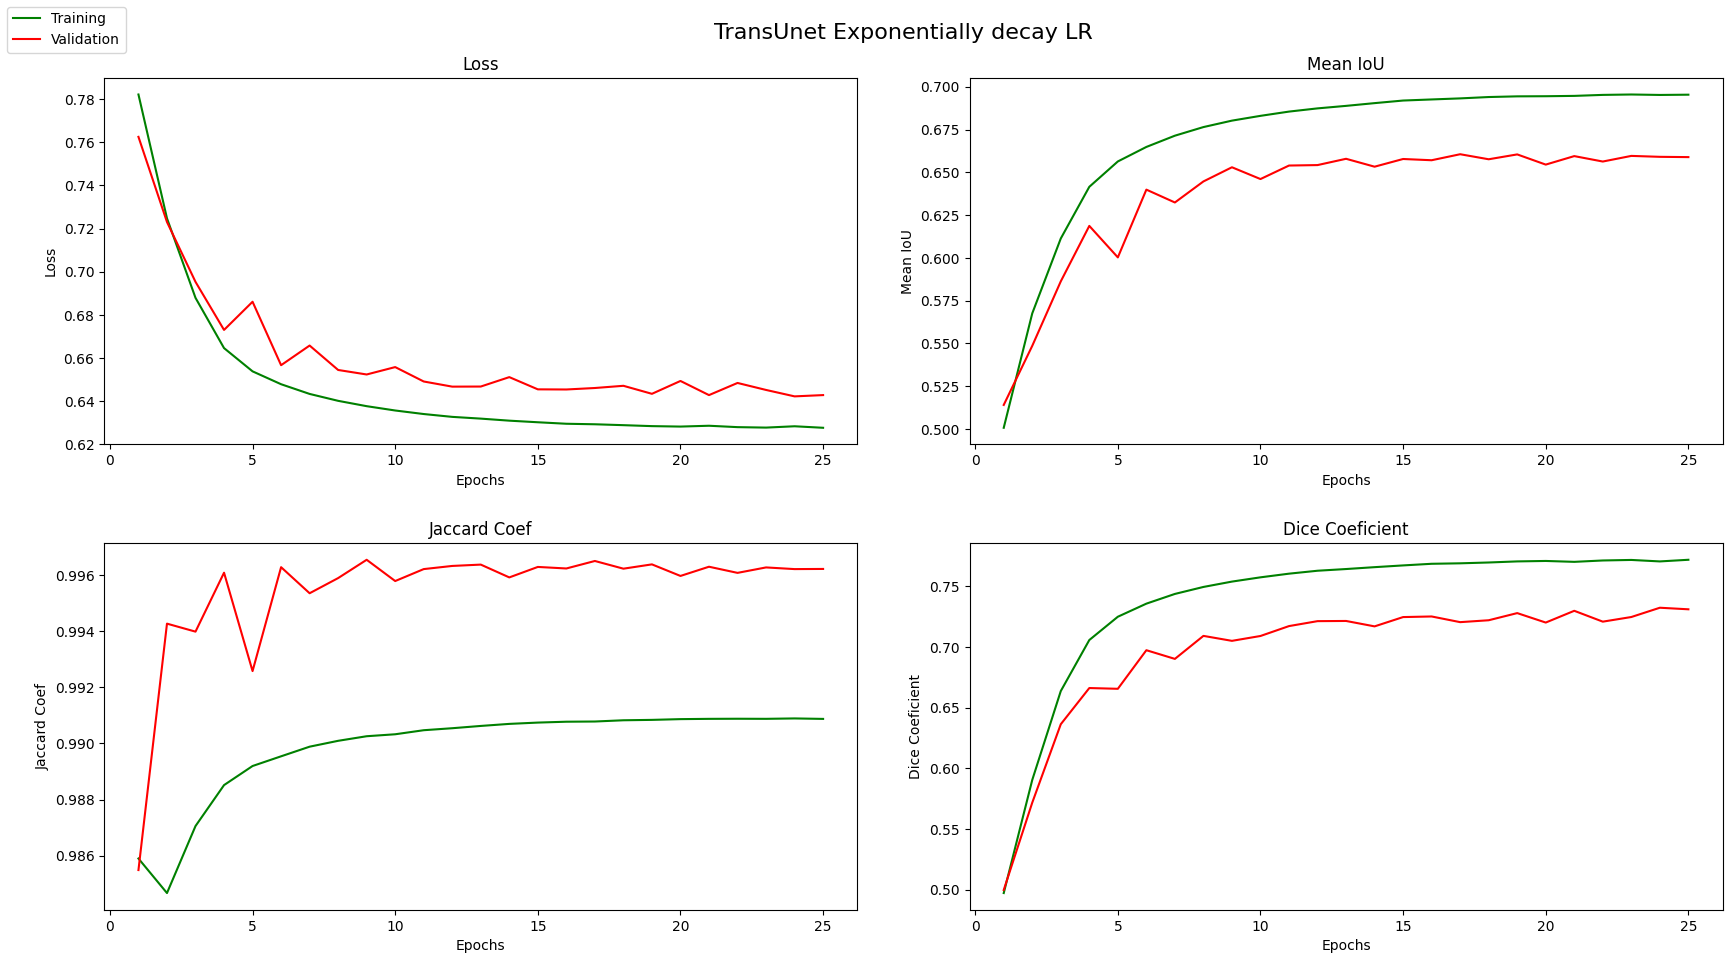

Model's last epoch's metrics:
loss = 0.6277
real_dice_coeff = 0.9954
Mean IOU = 0.6954
accuracy = 0.9955
jaccard_coef = 0.9909
Dice Coeficient = 0.7720
val_loss = 0.6428
val_real_dice_coeff = 0.9981
val_Mean IOU = 0.6589
val_accuracy = 0.9981
val_jaccard_coef = 0.9962
val_Dice Coeficient = 0.7312


In [16]:
# Plot model_name = "Unet_BCE_Dice_loss_real_dice_metric"
model_name = "Unet_BCE_Dice_loss_real_dice_metric"
with open(TRAIN_HISTORY_PATH + model_name + '_train_history.pkl', 'rb') as pfile:
    train_history = pickle.load(pfile)
visualize_train_curves(train_history, "TransUnet Exponentially decay LR")

# Image prediction visualization


In [37]:
from pandarallel import pandarallel
import multiprocessing

# To use all available CPUs
n_cpus = multiprocessing.cpu_count()
print('CPUs available: ', n_cpus)
pandarallel.initialize(progress_bar=True, nb_workers=n_cpus)

CPUs available:  4
INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [86]:

# Helper functions for visualization
def get_contrail_ratio(row):
    label = np.load(row[0] + str(row[1]) + '/human_pixel_masks.npy')
    return np.count_nonzero(label)/(256*256)


def display_image_and_label(path, record_id, contrail_ratio, model):
    label = np.load(path + str(record_id) + '/human_pixel_masks.npy')
    ash_image = np.load(path + str(record_id) + '/ash_image.npy')[...,4]
    y_pred = model.predict(ash_image.reshape(1,256, 256, 3))
    prediction = np.argmax(y_pred[0], axis=2)
    
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    fig.tight_layout(pad=5.0)


    ax[0].set_title("False color image")
    ax[0].imshow(ash_image)
    ax[0].axis('off')
  
    ax[1].imshow(label)
    ax[1].set_title("Label")
    ax[1].axis('off')
    
    ax[2].imshow(prediction)
    ax[2].set_title("Prediction")
    ax[2].axis('off')

    fig.suptitle(f'Record ID: {str(record_id)} \nContrail Ratio = {contrail_ratio:.5f}')

In [39]:
# Commented out so it is not processed again
# full_id_list_df['contrail_ratio'] = full_id_list_df.parallel_apply(get_contrail_ratio, axis=1)

# Store on disk to avoid recalculating multiple times
# full_id_list_df.to_json('../metadata/full_id_list_df.json')

# Then it can be read from file:
full_id_list_df = pd.read_json('../metadata/full_id_list_df.json')

In [83]:
# Load model for prediction
model = load_model('../../../fast-disk/w210-capstone/models/Baseline_Unet_Ash_Image_50_epochs.keras',custom_objects={'dice_loss_plus_5focal_loss': total_loss, 'jaccard_coef': jaccard_coef, 'IOU score' : sm.metrics.IOUScore(threshold=0.9, name="IOU score"), 'Dice Coeficient' : sm.metrics.FScore(threshold=0.6, name="Dice Coeficient")}, compile=False)

model.compile(optimizer="adam", 
              loss=total_loss, 
              metrics=metrics)

1/1 [==============================] - 0s 24ms/step


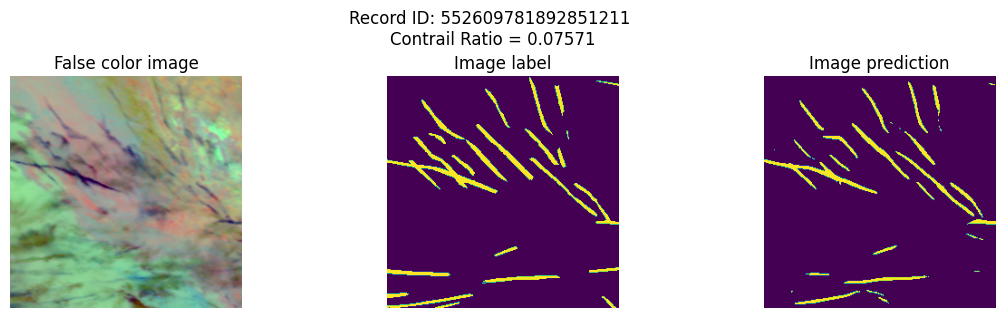

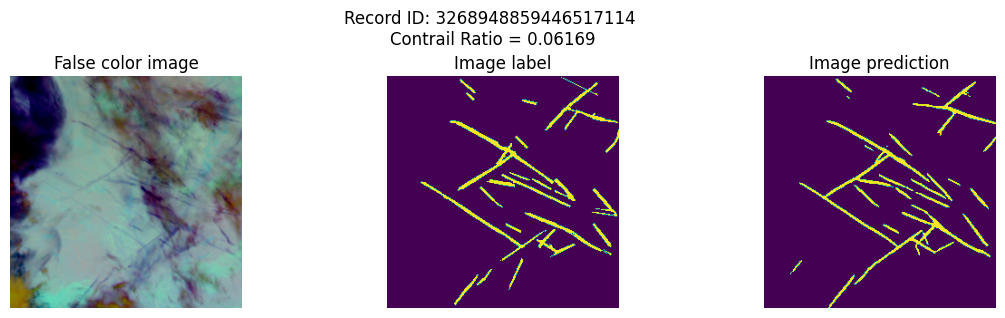

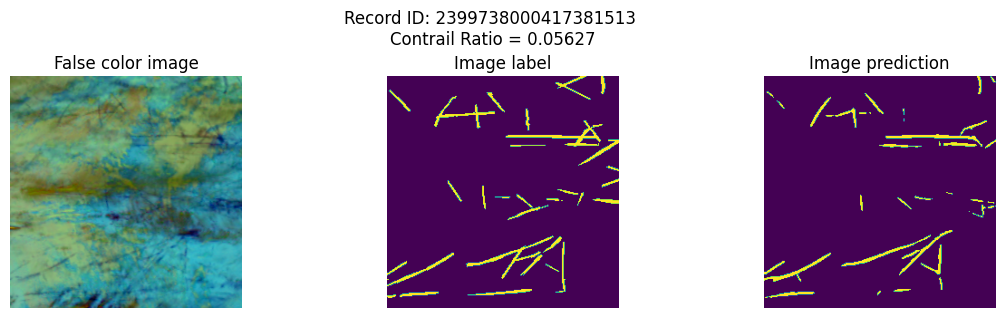

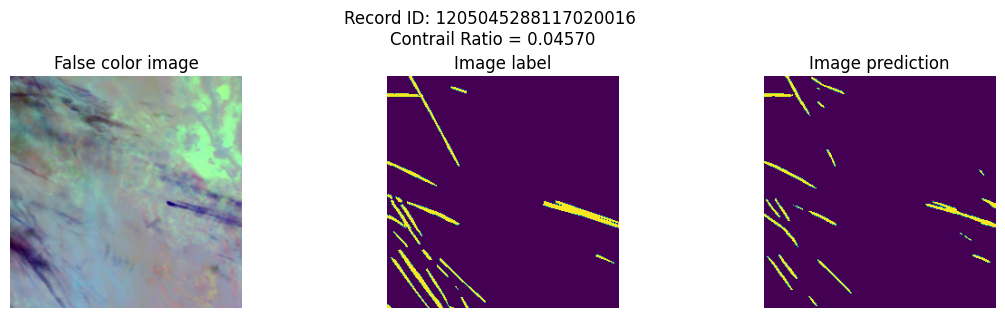

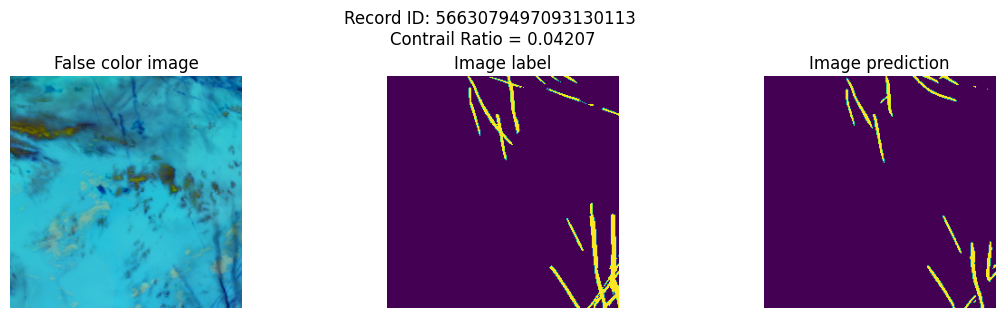

In [85]:
# Display the top N validation images with most contrails and compare with label
N = 5
# Get the top 10 validation records with more contrails (higher contrail ratio)
top_contrails_validation_records = full_id_list_df[full_id_list_df.path == VALIDATION_DIR].sort_values('contrail_ratio',ascending=False)[:N].values.tolist()

for record in top_contrails_validation_records:
    display_image_and_label(record[0], record[1], record[2], model)